# Iteration 10: Summary

This iteration produced one of my best results, like the previous iteration. The only configuration I changed from the previous iteration was decreasing the learning rate to 0.0001, since the anomaly was still there from Iteration 8.  This did drop the anomaly from the previous iteration as I had predicted (initial training loss went from 20 to 2), proving that the learning rate was too high.

Test results:

Accuracy 0.76
Loss 0.67

I also included the results of testing on a group of 25 images (5 per class), which my team will use to compare correctly classified and misclassified images between our 3 algorithms.

import shutil
import os

source = './food-101/test/ramen'
dest = './food-101/valid/ramen'

files = os.listdir(source)

i = 0
for f in files:
    if i < 175:
        file= os.path.join(source, f)
        shutil.move(file,dest)
        print("adding img ", i)
    i+=1

# Preprocessing and Loading Data

For loading the data, I first used the train/test split that was provided with our dataset.  This gave us 750 images in train and 250 in test PER CLASS.  Then, I split the test set into test & validation.  I moved 175 images to the validation set, thus we are left with 75 images in test.

For image preprocessing, I first resize each image to our IMG_SIZE constant, currently set to 224 pixels.  I then recolor the image to RGB.  I also assign the labels to the images and shuffle the dataset.


After loading the data, the shape of X (features) will be (-1 {this means any number of features}, IMG_SIZE, IMG_SIZE, 3 {number of channels - RGB}), and the shape of y (labels) will be (-1, 1).

In [1]:
    # importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt

import os
from os import listdir
from os.path import isfile, join

import cv2
import random
import datetime
import time
import shutil
import stat

import collections
from collections import defaultdict

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import to_categorical, plot_model

from keras.models import Model

Using TensorFlow backend.


In [2]:
# constants
IMG_SIZE = 224
NUM_CLASSES = 5
noodle_classes = ['pad_thai','pho','ramen','spaghetti_bolognese','spaghetti_carbonara']

# these are the main variables we tested and documented
EPOCHS = 40
BATCH_SZ = 64
LEARN_RATE = 0.0001

In [3]:
# function to create the datasets (train, test, and valid)
# preprocesses the images (resize/recolor), assigns labels, and shuffles the dataset
root_dir = 'food-101/images/'

def create_data(root, _name):
    data_set = []

    for noodle_class in noodle_classes:
        path = os.path.join(root, noodle_class)
        label = noodle_classes.index(noodle_class) # assign an integer label to the image based on our noodle_classes array
        print(noodle_class,label)

        for img in os.listdir(path): # iterates through each image in the noodle folder
                if img.startswith('.'):
                    continue
                # each image is a 2D array of RGB value
                try:
                    img_arr = cv2.imread(os.path.join(path,img)) 
                    img_to_rgb = img_arr[:,:,::-1] # recolor
                    new_img = cv2.resize(img_to_rgb,(IMG_SIZE,IMG_SIZE)) #resize
                    data_set.append([new_img,label]) # store image and label together in dataset so we can shuffle without images getting mislabeled
                except Exception as e: # catch bad images
                    print("create exception: ",e)
        
    # randomize
    random.shuffle(data_set)
    
    X = []
    y = []

    for features, label in data_set:
        X.append(features) # 2D array of RGB values representing features
        y.append(label) # integer representing class/label

    # reshape X and y
    X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
    y = np.array(y).reshape(-1, 1)
    print('X', X.shape)
    print('y', y.shape)

    return X,y

In [4]:
# load data in train, test, and valid

X_train, y_train = create_data('food-101/train', "train")
X_test, y_test = create_data('food-101/test', "test")
X_valid, y_valid = create_data('food-101/valid', "valid")

pad_thai 0
pho 1
ramen 2
spaghetti_bolognese 3
spaghetti_carbonara 4
X (3750, 224, 224, 3)
y (3750, 1)
pad_thai 0
pho 1
ramen 2
spaghetti_bolognese 3
spaghetti_carbonara 4
X (375, 224, 224, 3)
y (375, 1)
pad_thai 0
pho 1
ramen 2
spaghetti_bolognese 3
spaghetti_carbonara 4
X (875, 224, 224, 3)
y (875, 1)


# Data Normalization and Augmentation
Here I am normalizing the data to scale our input training vectors. This will help improve accuracy and increase training speed.

I also implement image augmentation to improve accuracy.

In [5]:
# normalize data
# X_train = X_train/255.0
# X_test = X_test/255.0

#print('X train before normalize',X_train[1])
print('y train before normal',y_train)
# input('wait1')

# L2-normalizes the given array, i.e., it makes the sum of squares of each element of the array to be equal to one
X_train = tf.keras.utils.normalize(X_train, axis=1)
y_train = tf.keras.utils.to_categorical(y_train, NUM_CLASSES)

#print('X train after normal',X_train[1])
print('y train after normal',y_train)

X_test = tf.keras.utils.normalize(X_test, axis=1)
y_test = tf.keras.utils.to_categorical(y_test, NUM_CLASSES)

X_valid = tf.keras.utils.normalize(X_valid, axis=1)
y_valid = tf.keras.utils.to_categorical(y_valid, NUM_CLASSES)

print(y_train.shape)

y train before normal [[0]
 [4]
 [1]
 ...
 [4]
 [2]
 [1]]
y train after normal [[1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]]
(3750, 5)


In [6]:
from keras.applications.vgg16 import preprocess_input

# image augmentation - for better performance
datagen = ImageDataGenerator(
    rotation_range = 90,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    horizontal_flip = True,
    brightness_range=[0.2,1.0],
    zoom_range=[0.5,1.0]
    #preprocessing_function=preprocess_input
)

datagener = datagen.flow(X_train, y_train, batch_size = BATCH_SZ, shuffle=True)
datagen.fit(X_train)

# image augmentation - for better performance
vdatagen = ImageDataGenerator(
    rotation_range = 90,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    horizontal_flip = True,
    brightness_range=[0.2,1.0],
    zoom_range=[0.5,1.0]
    #preprocessing_function=preprocess_input
)

vdatagener = vdatagen.flow(X_valid, y_valid, batch_size = BATCH_SZ, shuffle=True)
vdatagen.fit(X_valid)


# VGGNet
I have simplified the 16-layer architecture by removing the last two VGG blocks, leaving just 10 layers, as the original architecture was too complex for our dataset.  I also use LeakyReLU as I was getting extremely high loss values with the ReLU activation function.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 224, 224, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 224, 224, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 112, 112, 128)    

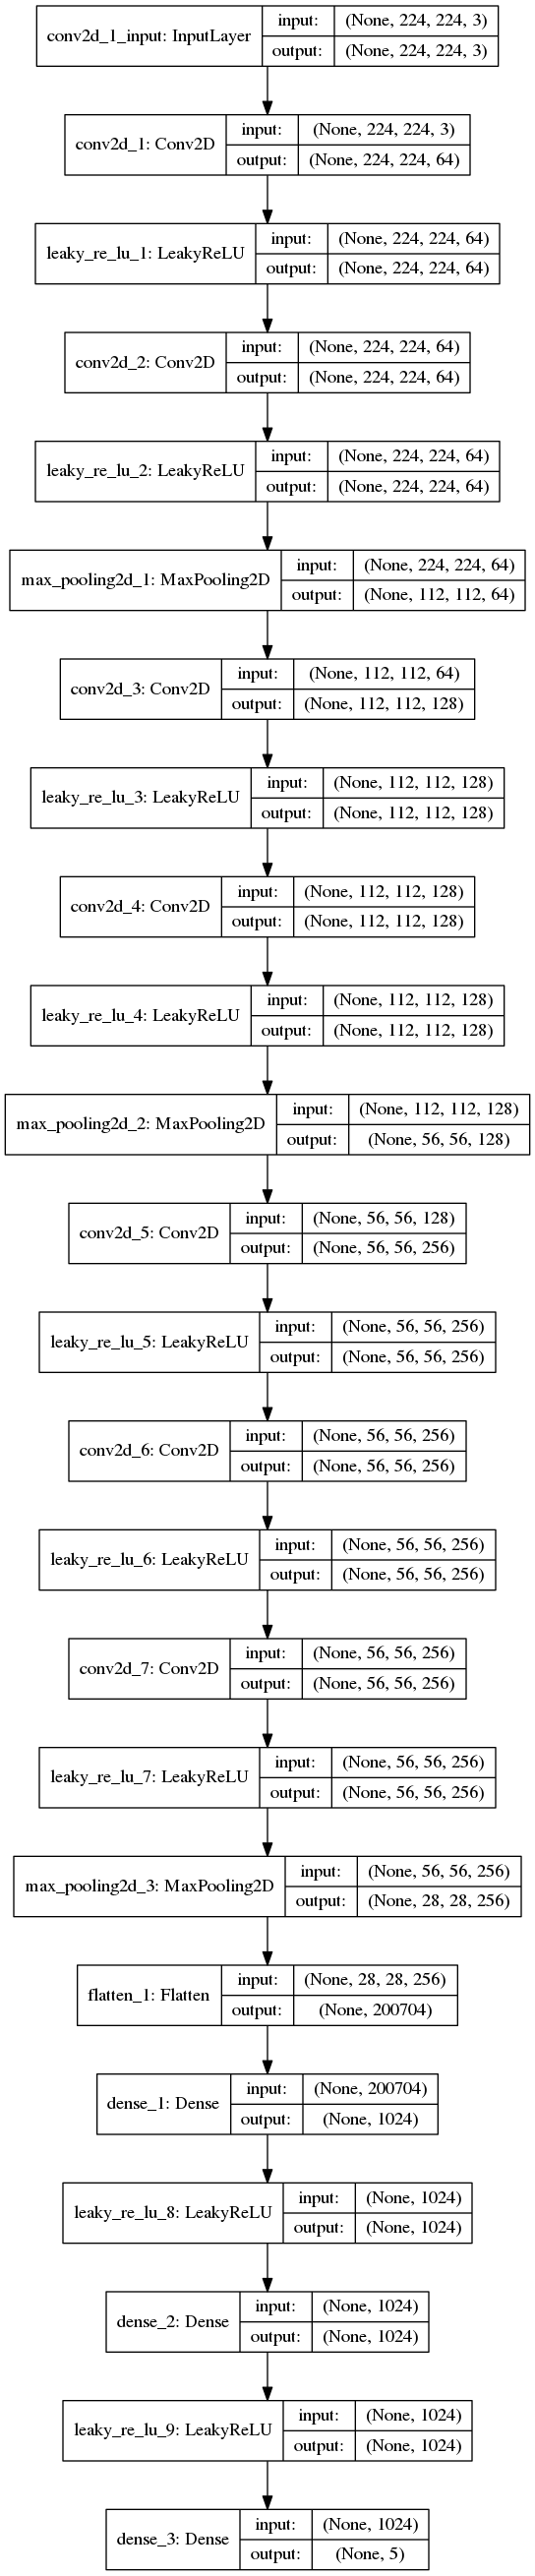

In [7]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, BatchNormalization, LeakyReLU
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.utils import plot_model

# creating the actual model using the VGGNet16 architecture

input_shape = (IMG_SIZE, IMG_SIZE, 3) # 224x224x3 RGB image

#Instantiate an empty model
model = Sequential([
Conv2D(64, (3, 3), input_shape=input_shape, kernel_initializer='glorot_normal', bias_initializer='zeros', padding='same'), # first two convolutional layers
LeakyReLU(alpha=0.01),
Conv2D(64, (3, 3), padding='same'),
LeakyReLU(alpha=0.01),
MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
Conv2D(128, (3, 3), padding='same'), 
LeakyReLU(alpha=0.01),
Conv2D(128, (3, 3), padding='same',), 
LeakyReLU(alpha=0.01),
MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
Conv2D(256, (3, 3), padding='same',),
LeakyReLU(alpha=0.01),
Conv2D(256, (3, 3), padding='same',),
LeakyReLU(alpha=0.01),
Conv2D(256, (3, 3), padding='same',),
LeakyReLU(alpha=0.01),
MaxPooling2D(pool_size=(2, 2), strides=(2, 2)), 
Flatten(), 
Dense(1024), # fully connected layers
LeakyReLU(alpha=0.01),
Dense(1024),
LeakyReLU(alpha=0.01),
Dense(5, activation='softmax') # softmax output layer, 5 possible values/classes
])

model.summary()

plot_model(model, show_shapes=True, to_file='vgg_block.png')

# Training

In [8]:
# compiling model and training
from keras.callbacks import ModelCheckpoint

opt = optimizers.SGD(lr=LEARN_RATE, momentum=.9) # momentum help accelerate gradient vectors in the right directions
a_opt = optimizers.Adam(lr=LEARN_RATE)

model.compile(loss="categorical_crossentropy",
              optimizer=a_opt,
              metrics=['accuracy'])
'''


# Compile the model
model.compile(loss="categorical_crossentropy", optimizer='SGD', metrics=['accuracy'])
'''
print(X_train.shape)
print(y_train.shape)

'''
# fitting model without image augmentation
model.fit(X_train, 
          y_train, 
          batch_size=BATCH_SZ, 
          epochs=EPOCHS,     
          validation_data=(X_valid, y_valid))
'''
checkpointer = ModelCheckpoint(filepath='/home/jupyter/weights.{epoch:02d}-{val_loss:.2f}.hdf5', verbose=1, save_best_only=True)
callbacks=[checkpointer]

# fitting model with image augmentation
history = model.fit_generator(datagener,
                    steps_per_epoch=X_train.shape[0] // BATCH_SZ,
                    epochs=EPOCHS,
                    validation_data=vdatagener,
                    shuffle=True)

(3750, 224, 224, 3)
(3750, 5)
Epoch 1/40
58/58 [==============================] - 1067s 18s/step - loss: 3.1611 - accuracy: 0.3163 - val_loss: 1.2065 - val_accuracy: 0.4549
Epoch 2/40
58/58 [==============================] - 1062s 18s/step - loss: 1.3427 - accuracy: 0.4585 - val_loss: 1.2438 - val_accuracy: 0.4914
Epoch 3/40
58/58 [==============================] - 1063s 18s/step - loss: 1.3032 - accuracy: 0.4731 - val_loss: 1.1666 - val_accuracy: 0.5177
Epoch 4/40
58/58 [==============================] - 1070s 18s/step - loss: 1.2167 - accuracy: 0.5236 - val_loss: 1.0327 - val_accuracy: 0.5383
Epoch 5/40
58/58 [==============================] - 1064s 18s/step - loss: 1.1697 - accuracy: 0.5507 - val_loss: 1.0905 - val_accuracy: 0.5554
Epoch 6/40
58/58 [==============================] - 1059s 18s/step - loss: 1.1348 - accuracy: 0.5589 - val_loss: 0.9928 - val_accuracy: 0.5966
Epoch 7/40
58/58 [==============================] - 1065s 18s/step - loss: 1.1254 - accuracy: 0.5792 - val_loss:

# Visualization: Model Accuracy & Loss

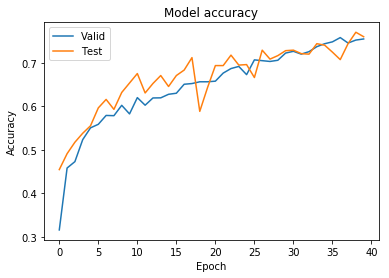

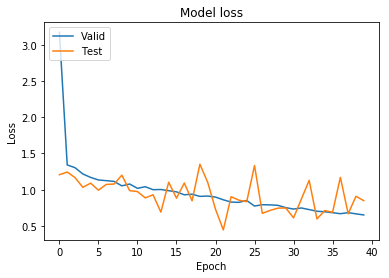

In [14]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Valid', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Valid', 'Test'], loc='upper left')
plt.show()

# Evaluation

In [15]:
# EVALUATION USING THE TEST SET OF 375 IMAGES
tdatagen = ImageDataGenerator()

tdatagener = vdatagen.flow(X_test, y_test, batch_size = BATCH_SZ, shuffle=False)
tdatagen.fit(X_test)

scores = model.evaluate_generator(tdatagener, verbose=1)
print('Test Loss: ', scores[0])
print('Test Accuracy: ', scores[1])

6/6 [==============================] - 32s 5s/step
Test Loss:  0.6722292900085449
Test Accuracy:  0.762666642665863


# Evaluation on Test Group of 25 Images
This is simply to make it easier for us to compare correctly classified and misclassified samples between our 3 algorithms.

In [16]:
# NEXT WE ARE EVALUATING ON OUR TEST GROUP OF 25 IMAGES
import matplotlib.pyplot as plt
tdatagener.reset()
tdatagen.fit(X_test)

predictions = model.predict_generator(tdatagener)

In [17]:
pred_classes = predictions.argmax(axis=-1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


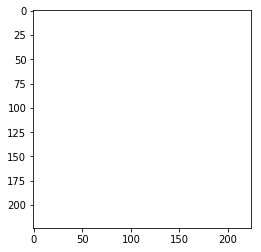

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  ramen
Actual Class:  ramen
CORRECT


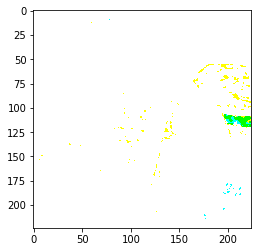

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pho
Actual Class:  pho
CORRECT


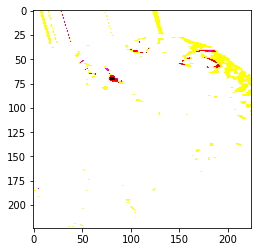

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pho
Actual Class:  ramen


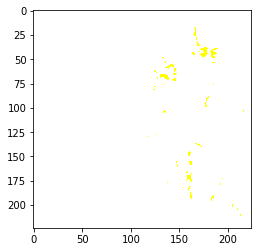

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pho
Actual Class:  pho
CORRECT


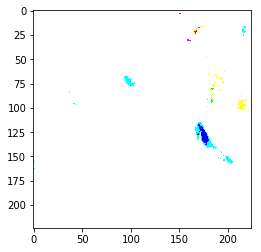

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  ramen
Actual Class:  pho


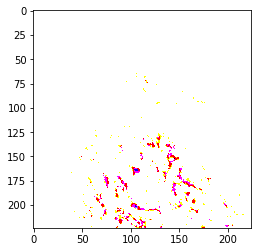

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_bolognese
Actual Class:  spaghetti_bolognese
CORRECT


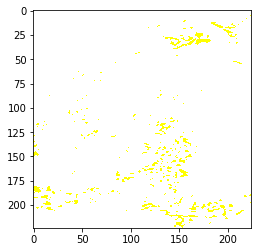

Predicted Class:  pad_thai
Actual Class:  pho


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


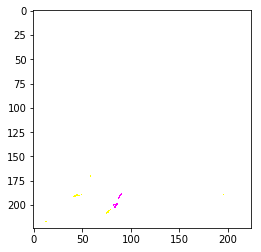

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_bolognese
Actual Class:  spaghetti_bolognese
CORRECT


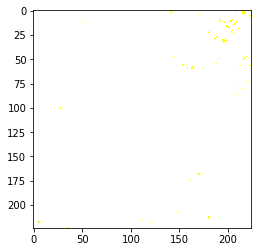

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_carbonara
Actual Class:  spaghetti_carbonara
CORRECT


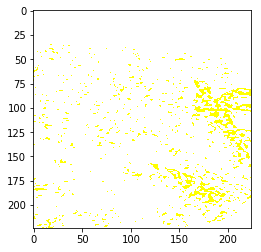

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pad_thai
Actual Class:  pad_thai
CORRECT


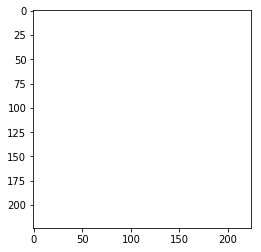

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  ramen
Actual Class:  pho


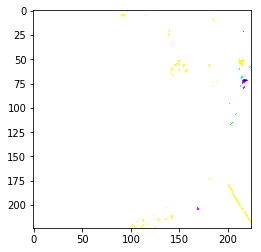

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pho
Actual Class:  ramen


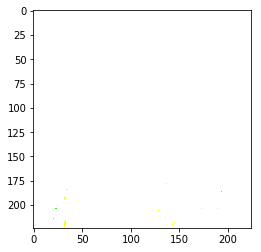

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pho
Actual Class:  pho
CORRECT


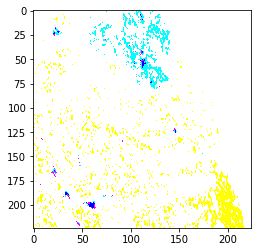

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_bolognese
Actual Class:  spaghetti_bolognese
CORRECT


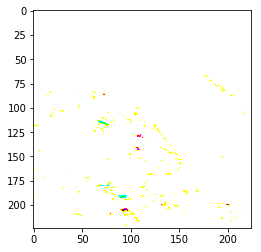

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_carbonara
Actual Class:  spaghetti_carbonara
CORRECT


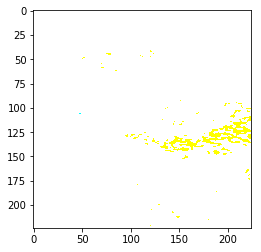

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  ramen
Actual Class:  ramen
CORRECT


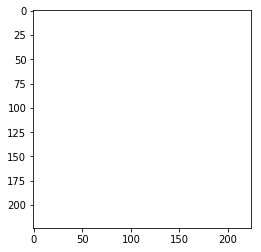

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_carbonara
Actual Class:  spaghetti_carbonara
CORRECT


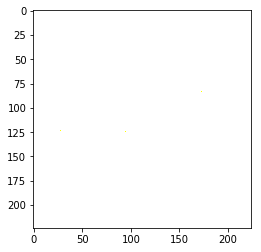

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pho
Actual Class:  pho
CORRECT


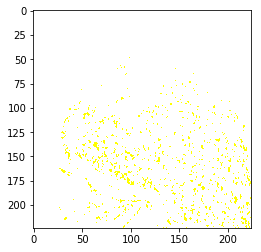

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_bolognese
Actual Class:  spaghetti_bolognese
CORRECT


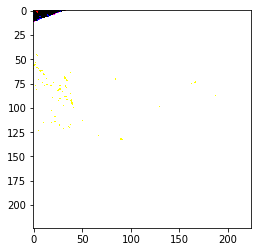

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_carbonara
Actual Class:  spaghetti_carbonara
CORRECT


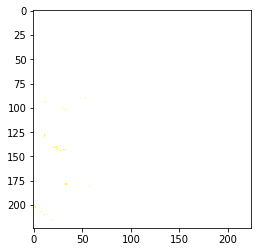

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_carbonara
Actual Class:  pad_thai


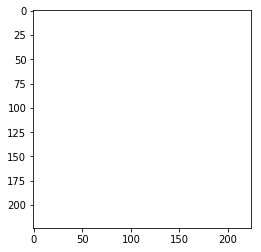

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pho
Actual Class:  pho
CORRECT


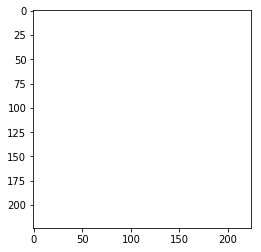

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pad_thai
Actual Class:  pad_thai
CORRECT


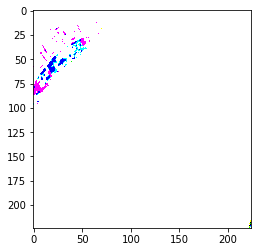

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  ramen
Actual Class:  ramen
CORRECT


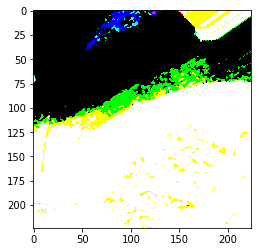

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  ramen
Actual Class:  pad_thai


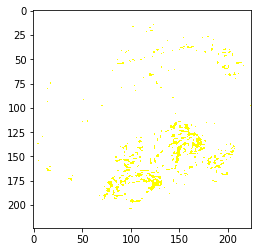

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_bolognese
Actual Class:  spaghetti_bolognese
CORRECT


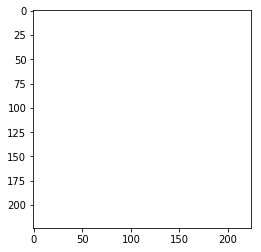

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pad_thai
Actual Class:  pad_thai
CORRECT


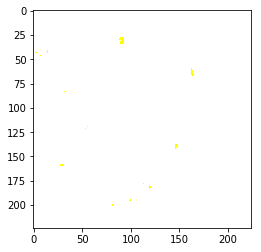

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_carbonara
Actual Class:  spaghetti_carbonara
CORRECT


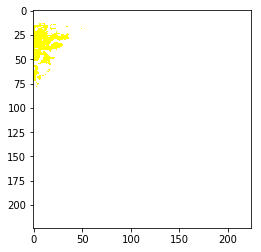

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  ramen
Actual Class:  ramen
CORRECT


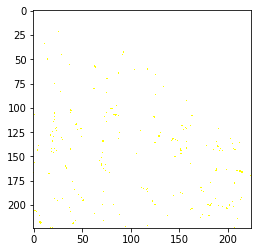

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_carbonara
Actual Class:  spaghetti_carbonara
CORRECT


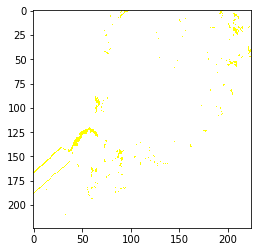

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  ramen
Actual Class:  pad_thai


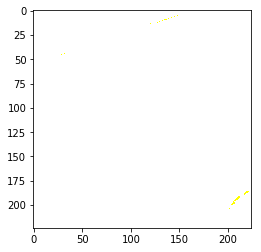

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pho
Actual Class:  pho
CORRECT


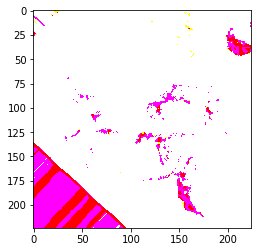

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  ramen
Actual Class:  ramen
CORRECT


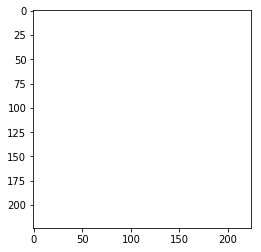

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pho
Actual Class:  pho
CORRECT


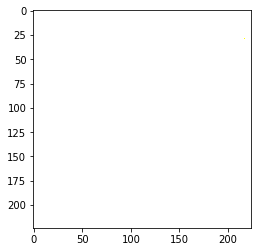

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pho
Actual Class:  pho
CORRECT


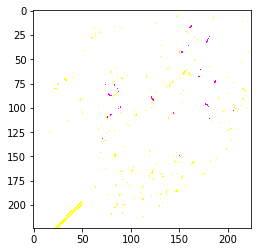

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_bolognese
Actual Class:  spaghetti_bolognese
CORRECT


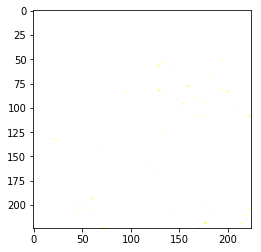

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pho
Actual Class:  pho
CORRECT


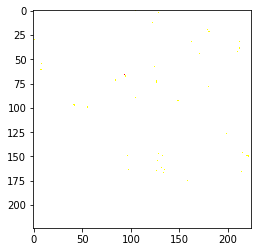

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pad_thai
Actual Class:  pad_thai
CORRECT


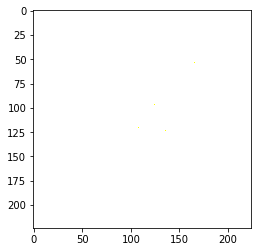

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_bolognese
Actual Class:  spaghetti_bolognese
CORRECT


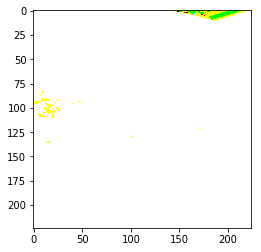

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_carbonara
Actual Class:  spaghetti_carbonara
CORRECT


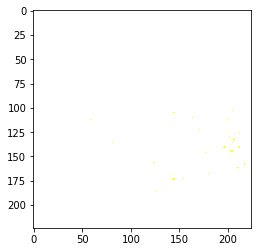

Predicted Class:  spaghetti_carbonara
Actual Class:  pad_thai


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


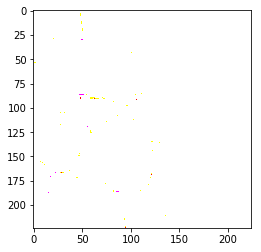

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  ramen
Actual Class:  ramen
CORRECT


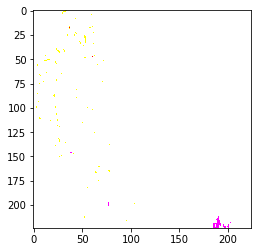

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_bolognese
Actual Class:  spaghetti_bolognese
CORRECT


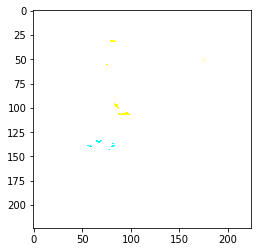

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  ramen
Actual Class:  ramen
CORRECT


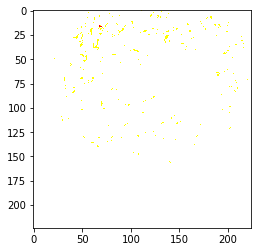

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_bolognese
Actual Class:  spaghetti_bolognese
CORRECT


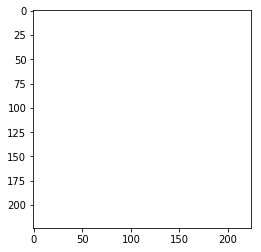

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  ramen
Actual Class:  ramen
CORRECT


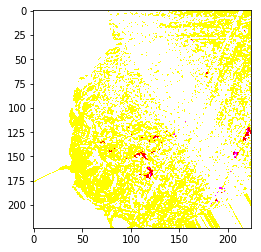

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_bolognese
Actual Class:  spaghetti_bolognese
CORRECT


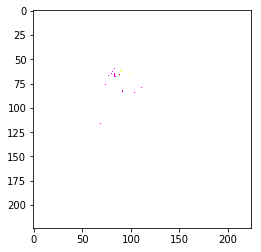

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  ramen
Actual Class:  ramen
CORRECT


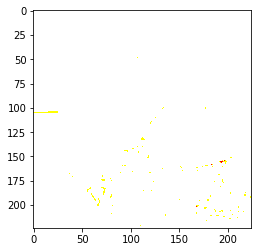

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_bolognese
Actual Class:  spaghetti_bolognese
CORRECT


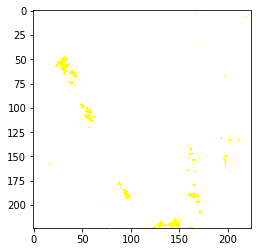

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_carbonara
Actual Class:  spaghetti_carbonara
CORRECT


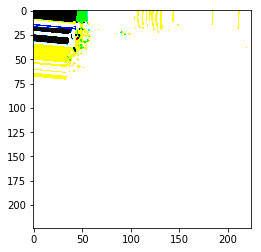

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  ramen
Actual Class:  ramen
CORRECT


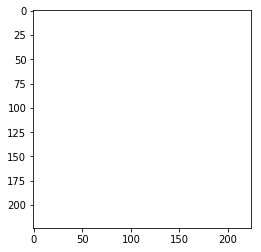

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_bolognese
Actual Class:  spaghetti_bolognese
CORRECT


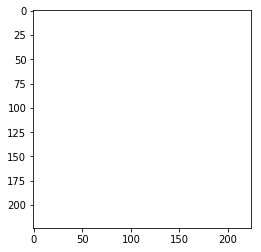

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pho
Actual Class:  pho
CORRECT


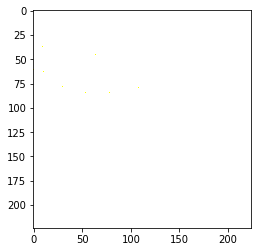

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pad_thai
Actual Class:  pad_thai
CORRECT


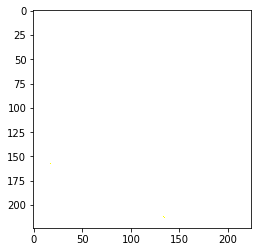

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_carbonara
Actual Class:  spaghetti_carbonara
CORRECT


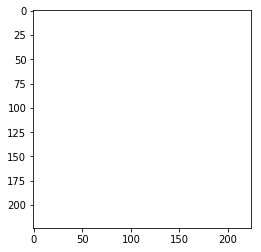

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  ramen
Actual Class:  pho


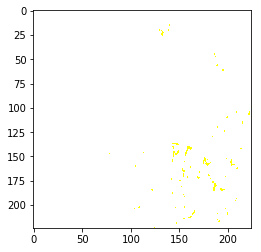

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_bolognese
Actual Class:  pad_thai


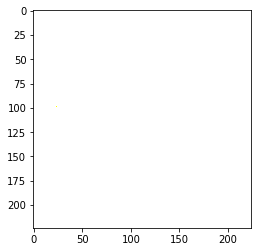

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  ramen
Actual Class:  ramen
CORRECT


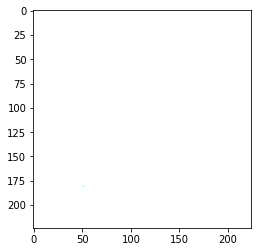

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pho
Actual Class:  pho
CORRECT


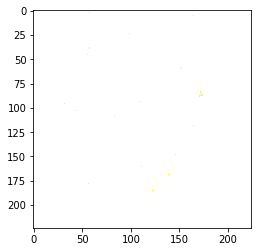

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_carbonara
Actual Class:  pad_thai


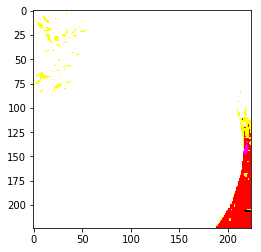

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pho
Actual Class:  pho
CORRECT


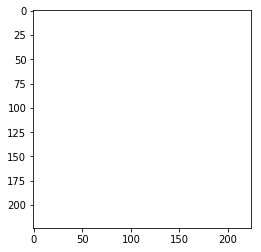

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pho
Actual Class:  pho
CORRECT


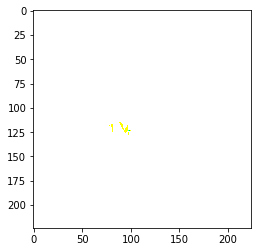

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pho
Actual Class:  pho
CORRECT


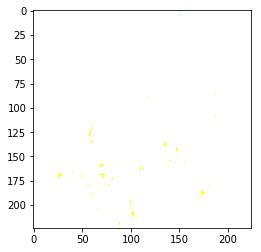

Predicted Class:  spaghetti_carbonara
Actual Class:  spaghetti_carbonara
CORRECT


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


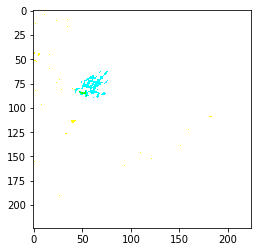

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pad_thai
Actual Class:  spaghetti_bolognese


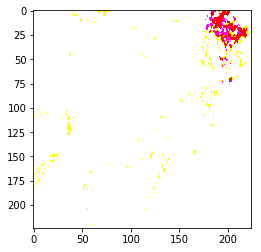

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pho
Actual Class:  pad_thai


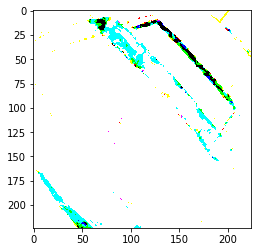

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  ramen
Actual Class:  ramen
CORRECT


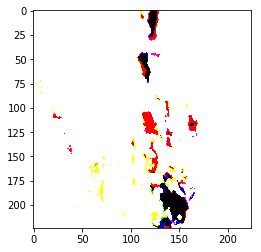

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  ramen
Actual Class:  ramen
CORRECT


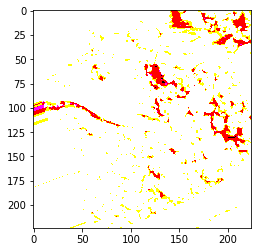

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_bolognese
Actual Class:  spaghetti_bolognese
CORRECT


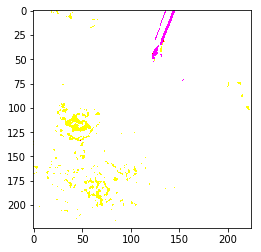

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_carbonara
Actual Class:  spaghetti_bolognese


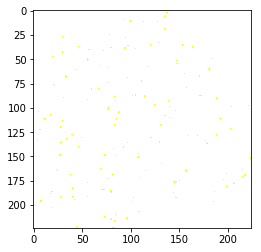

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_bolognese
Actual Class:  pad_thai


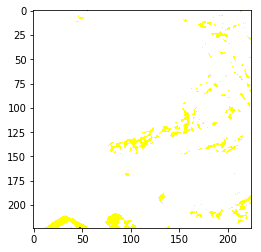

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  ramen
Actual Class:  ramen
CORRECT


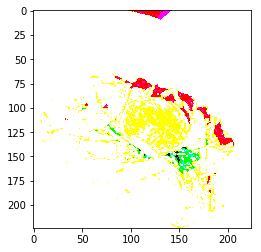

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  ramen
Actual Class:  spaghetti_carbonara


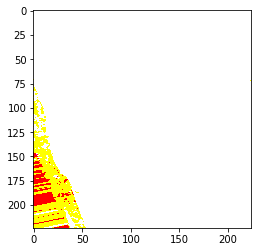

Predicted Class:  pho
Actual Class:  pho
CORRECT


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


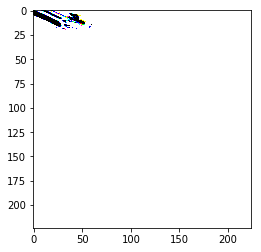

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pho
Actual Class:  pho
CORRECT


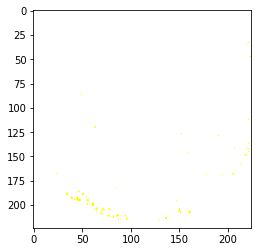

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_bolognese
Actual Class:  spaghetti_bolognese
CORRECT


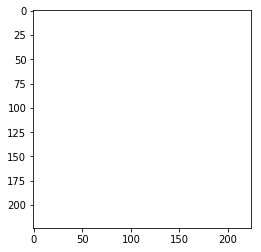

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  ramen
Actual Class:  ramen
CORRECT


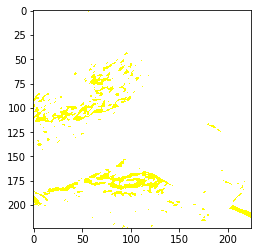

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  ramen
Actual Class:  spaghetti_bolognese


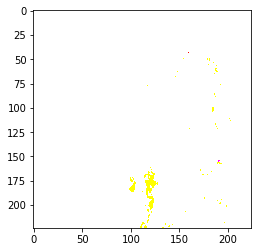

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_bolognese
Actual Class:  spaghetti_bolognese
CORRECT


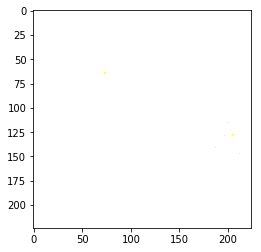

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_bolognese
Actual Class:  pad_thai


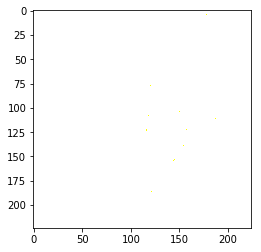

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pad_thai
Actual Class:  pad_thai
CORRECT


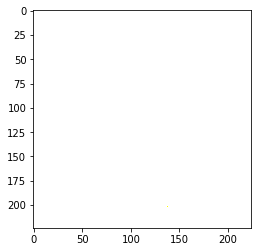

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  ramen
Actual Class:  ramen
CORRECT


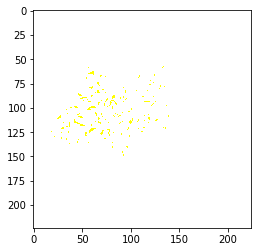

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_bolognese
Actual Class:  spaghetti_bolognese
CORRECT


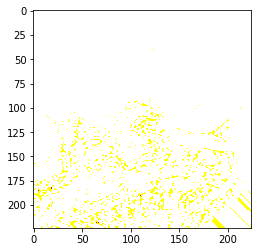

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_bolognese
Actual Class:  pad_thai


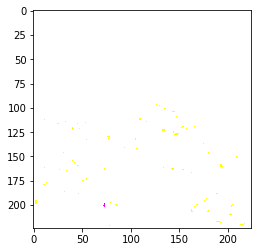

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pad_thai
Actual Class:  pad_thai
CORRECT


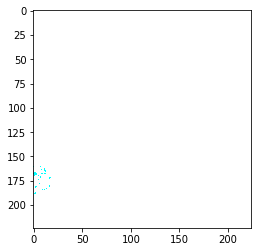

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  ramen
Actual Class:  ramen
CORRECT


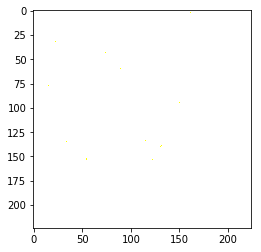

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_bolognese
Actual Class:  pad_thai


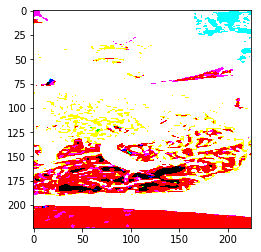

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_bolognese
Actual Class:  pad_thai


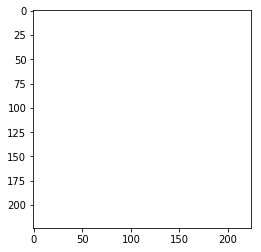

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pad_thai
Actual Class:  pad_thai
CORRECT


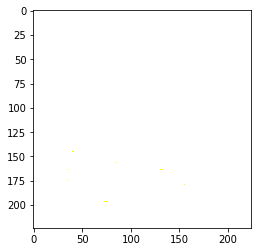

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pho
Actual Class:  ramen


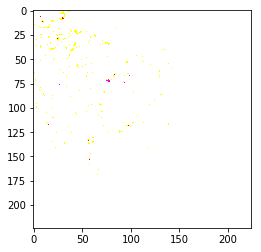

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_bolognese
Actual Class:  spaghetti_bolognese
CORRECT


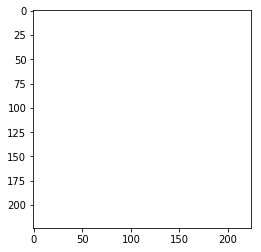

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pho
Actual Class:  pho
CORRECT


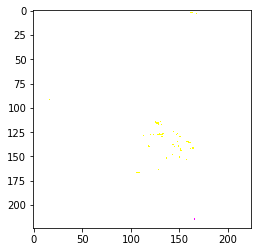

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pho
Actual Class:  pho
CORRECT


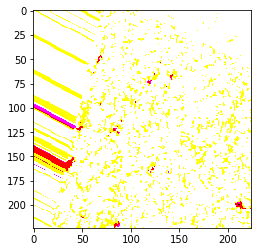

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_bolognese
Actual Class:  spaghetti_bolognese
CORRECT


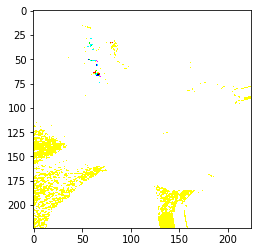

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  ramen
Actual Class:  ramen
CORRECT


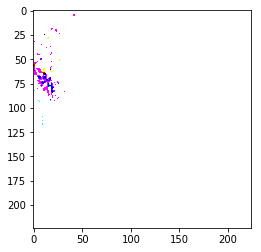

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  ramen
Actual Class:  pho


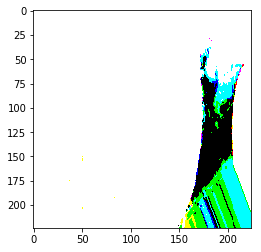

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pho
Actual Class:  pho
CORRECT


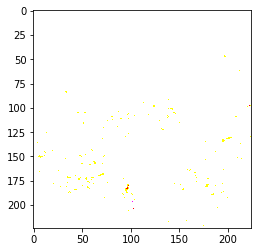

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pad_thai
Actual Class:  spaghetti_bolognese


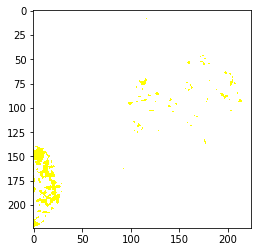

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  ramen
Actual Class:  ramen
CORRECT


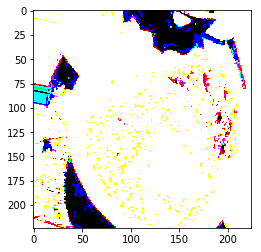

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  ramen
Actual Class:  ramen
CORRECT


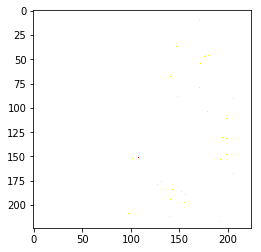

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pad_thai
Actual Class:  pad_thai
CORRECT


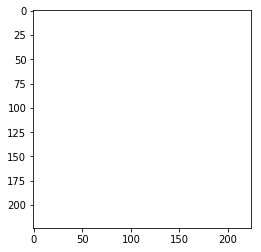

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_bolognese
Actual Class:  spaghetti_bolognese
CORRECT


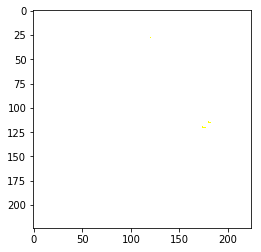

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_carbonara
Actual Class:  spaghetti_carbonara
CORRECT


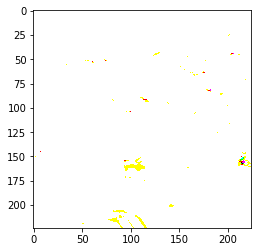

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_bolognese
Actual Class:  spaghetti_bolognese
CORRECT


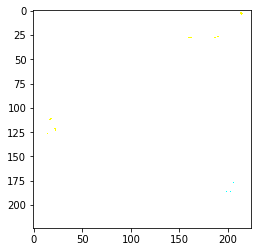

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pho
Actual Class:  pho
CORRECT


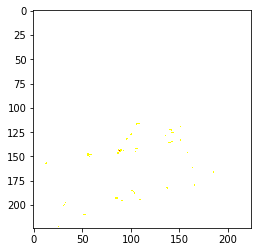

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_carbonara
Actual Class:  spaghetti_carbonara
CORRECT


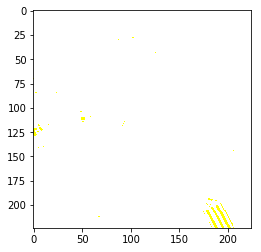

Predicted Class:  pho
Actual Class:  pho
CORRECT


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


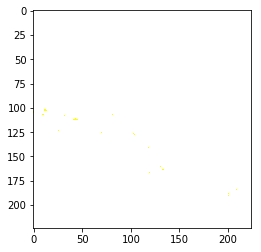

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_bolognese
Actual Class:  spaghetti_bolognese
CORRECT


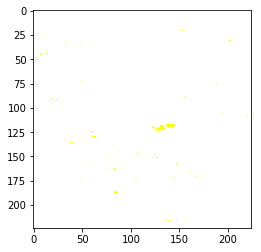

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_carbonara
Actual Class:  spaghetti_carbonara
CORRECT


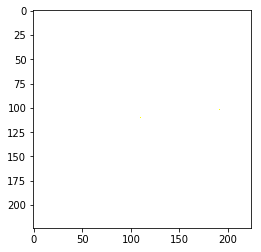

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pad_thai
Actual Class:  pad_thai
CORRECT


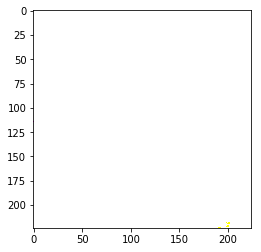

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  ramen
Actual Class:  spaghetti_carbonara


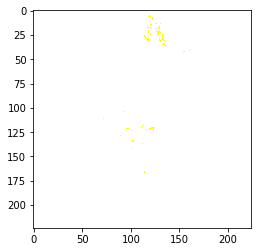

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pho
Actual Class:  pho
CORRECT


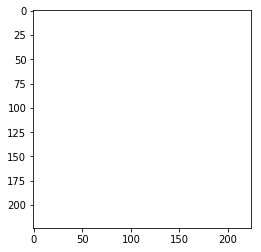

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_carbonara
Actual Class:  spaghetti_carbonara
CORRECT


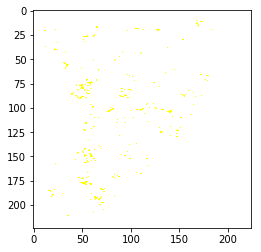

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_bolognese
Actual Class:  pad_thai


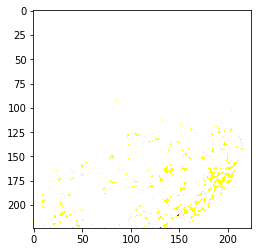

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_bolognese
Actual Class:  ramen


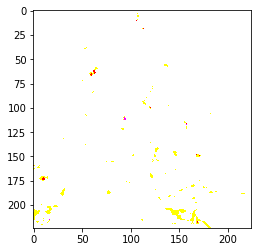

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_bolognese
Actual Class:  spaghetti_bolognese
CORRECT


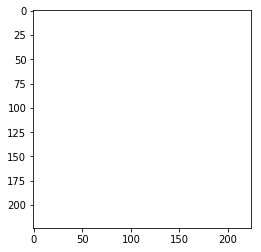

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_carbonara
Actual Class:  spaghetti_carbonara
CORRECT


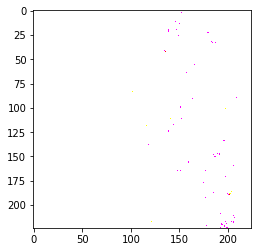

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_bolognese
Actual Class:  spaghetti_bolognese
CORRECT


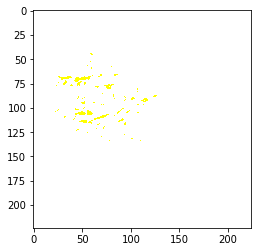

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_bolognese
Actual Class:  spaghetti_bolognese
CORRECT


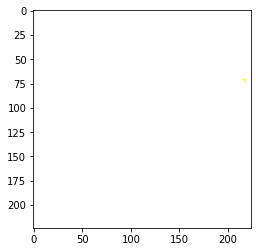

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  ramen
Actual Class:  ramen
CORRECT


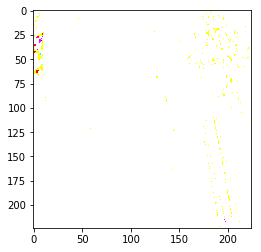

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  ramen
Actual Class:  ramen
CORRECT


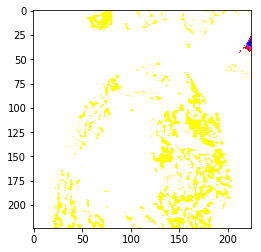

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pho
Actual Class:  pho
CORRECT


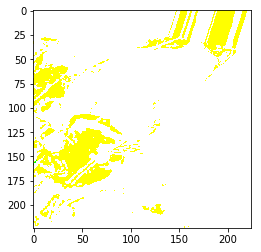

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  ramen
Actual Class:  spaghetti_carbonara


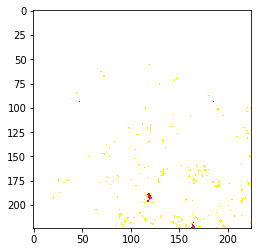

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_bolognese
Actual Class:  spaghetti_bolognese
CORRECT


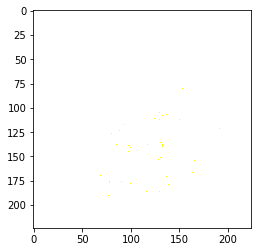

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_carbonara
Actual Class:  pad_thai


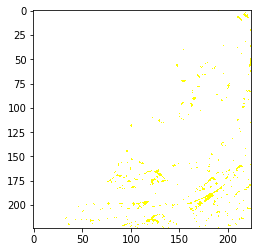

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  ramen
Actual Class:  spaghetti_carbonara


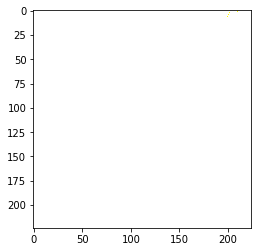

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_carbonara
Actual Class:  spaghetti_carbonara
CORRECT


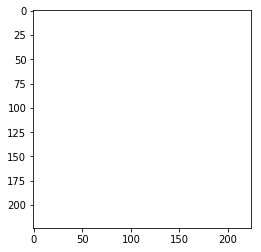

Predicted Class:  pho
Actual Class:  pho
CORRECT


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


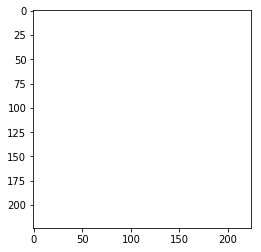

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_bolognese
Actual Class:  pad_thai


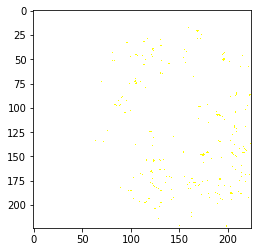

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pad_thai
Actual Class:  spaghetti_bolognese


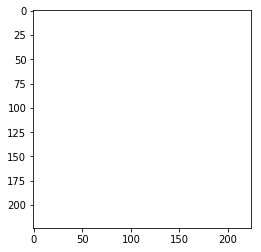

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_carbonara
Actual Class:  spaghetti_carbonara
CORRECT


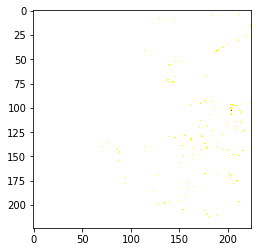

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_bolognese
Actual Class:  spaghetti_bolognese
CORRECT


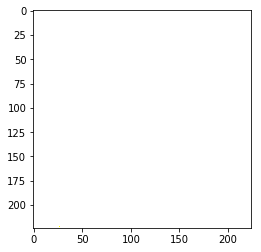

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  ramen
Actual Class:  pho


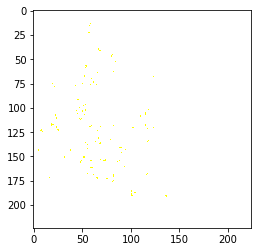

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_bolognese
Actual Class:  spaghetti_bolognese
CORRECT


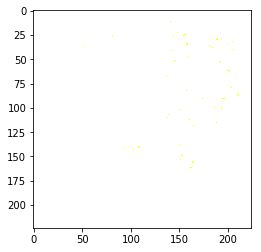

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_carbonara
Actual Class:  pad_thai


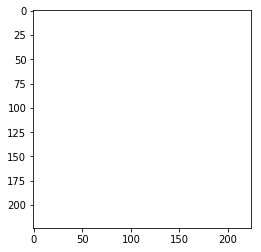

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  ramen
Actual Class:  ramen
CORRECT


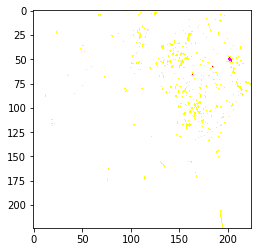

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  ramen
Actual Class:  ramen
CORRECT


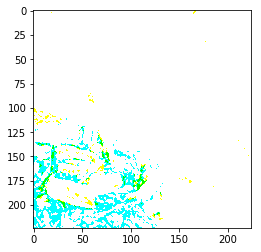

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  ramen
Actual Class:  ramen
CORRECT


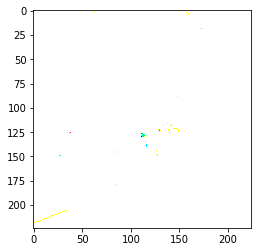

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_carbonara
Actual Class:  spaghetti_carbonara
CORRECT


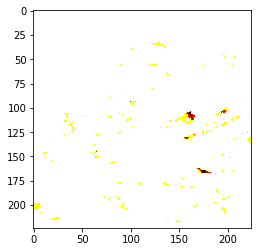

Predicted Class:  pad_thai
Actual Class:  pad_thai
CORRECT


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


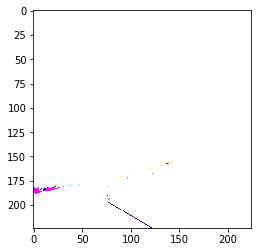

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_carbonara
Actual Class:  spaghetti_carbonara
CORRECT


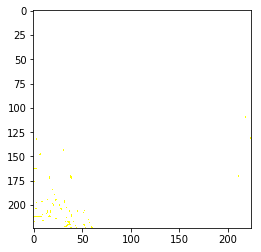

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  ramen
Actual Class:  ramen
CORRECT


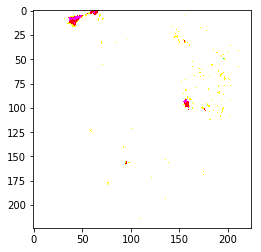

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_bolognese
Actual Class:  spaghetti_bolognese
CORRECT


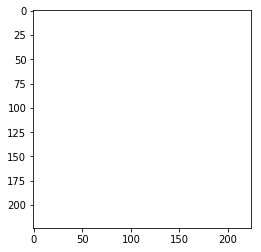

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_bolognese
Actual Class:  spaghetti_bolognese
CORRECT


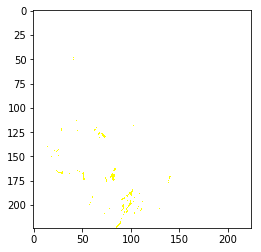

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pad_thai
Actual Class:  pad_thai
CORRECT


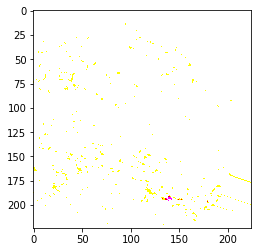

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_bolognese
Actual Class:  spaghetti_bolognese
CORRECT


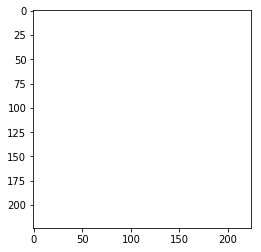

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_carbonara
Actual Class:  spaghetti_carbonara
CORRECT


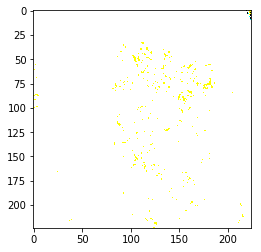

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_carbonara
Actual Class:  spaghetti_bolognese


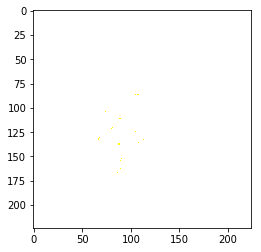

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_bolognese
Actual Class:  spaghetti_carbonara


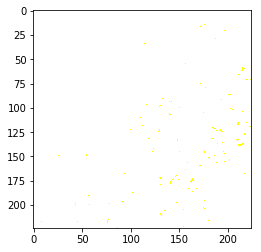

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pad_thai
Actual Class:  pad_thai
CORRECT


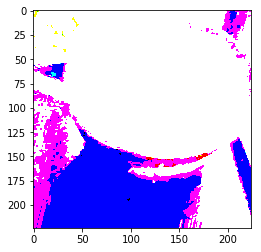

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  ramen
Actual Class:  ramen
CORRECT


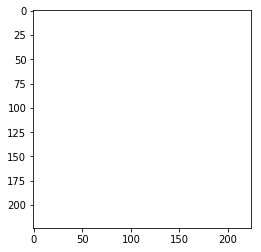

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_carbonara
Actual Class:  pad_thai


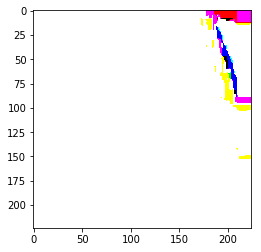

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_carbonara
Actual Class:  spaghetti_carbonara
CORRECT


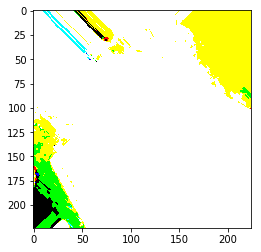

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  ramen
Actual Class:  spaghetti_carbonara


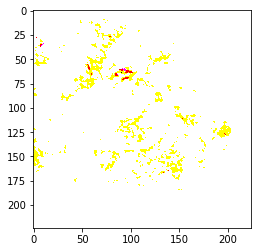

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_carbonara
Actual Class:  spaghetti_carbonara
CORRECT


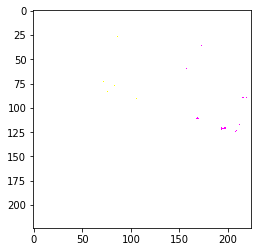

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_bolognese
Actual Class:  spaghetti_carbonara


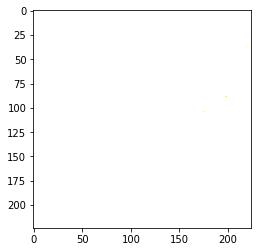

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_carbonara
Actual Class:  spaghetti_carbonara
CORRECT


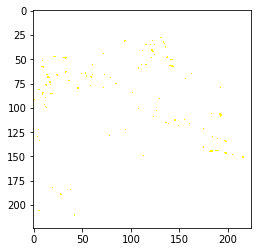

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pho
Actual Class:  pho
CORRECT


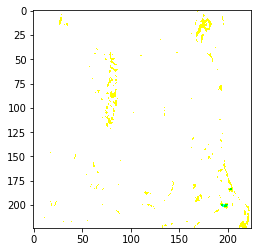

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pad_thai
Actual Class:  pad_thai
CORRECT


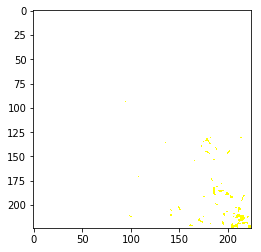

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_bolognese
Actual Class:  spaghetti_bolognese
CORRECT


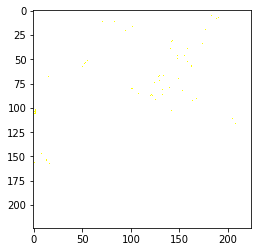

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  ramen
Actual Class:  ramen
CORRECT


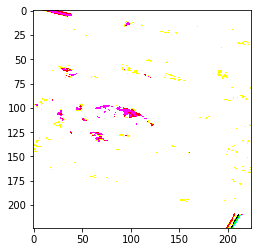

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_carbonara
Actual Class:  spaghetti_carbonara
CORRECT


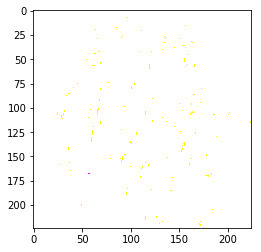

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_bolognese
Actual Class:  spaghetti_bolognese
CORRECT


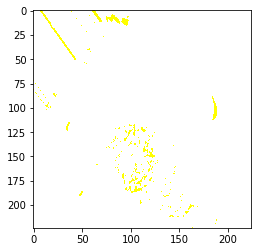

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  ramen
Actual Class:  ramen
CORRECT


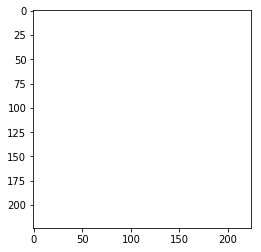

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_bolognese
Actual Class:  pho


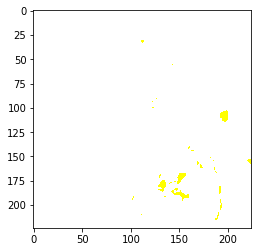

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pho
Actual Class:  pho
CORRECT


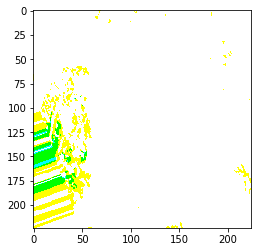

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pho
Actual Class:  pho
CORRECT


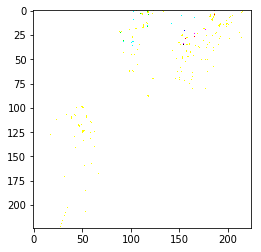

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  ramen
Actual Class:  ramen
CORRECT


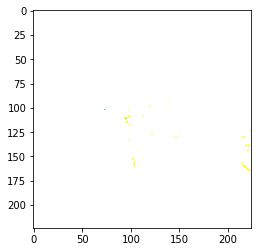

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  ramen
Actual Class:  ramen
CORRECT


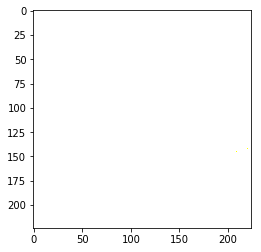

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pho
Actual Class:  pho
CORRECT


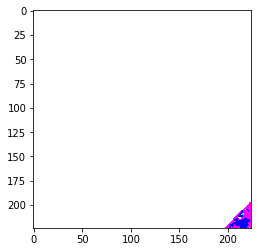

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_carbonara
Actual Class:  spaghetti_carbonara
CORRECT


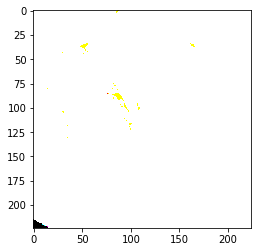

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pho
Actual Class:  ramen


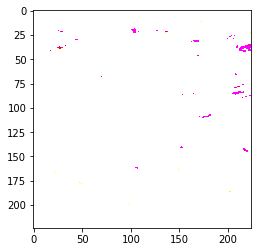

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_bolognese
Actual Class:  spaghetti_bolognese
CORRECT


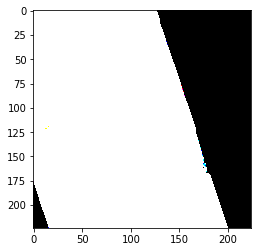

Predicted Class:  pad_thai
Actual Class:  pad_thai
CORRECT


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


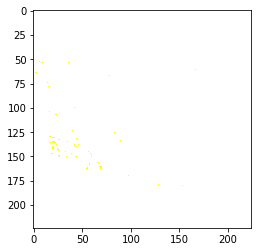

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pho
Actual Class:  pho
CORRECT


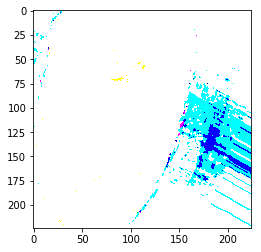

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  ramen
Actual Class:  ramen
CORRECT


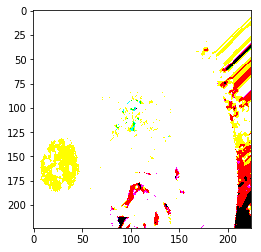

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  ramen
Actual Class:  ramen
CORRECT


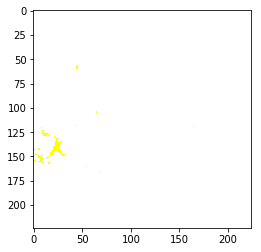

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  ramen
Actual Class:  ramen
CORRECT


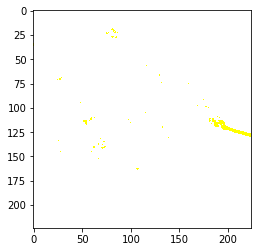

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pad_thai
Actual Class:  pad_thai
CORRECT


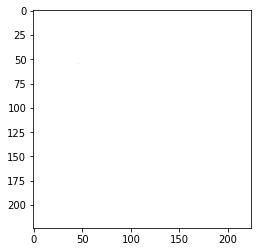

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pho
Actual Class:  pad_thai


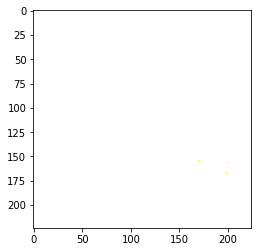

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_bolognese
Actual Class:  spaghetti_bolognese
CORRECT


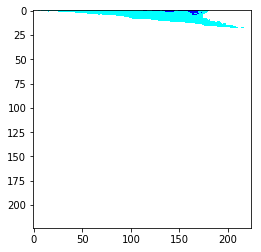

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_carbonara
Actual Class:  spaghetti_carbonara
CORRECT


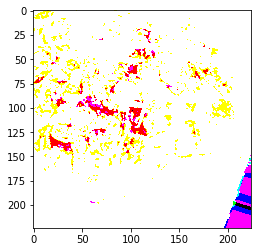

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_bolognese
Actual Class:  pho


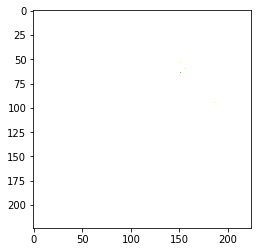

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_carbonara
Actual Class:  spaghetti_carbonara
CORRECT


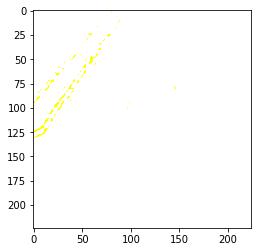

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pho
Actual Class:  pho
CORRECT


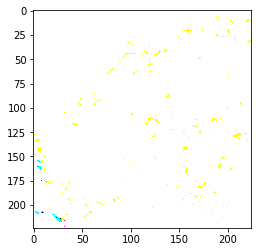

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_carbonara
Actual Class:  pad_thai


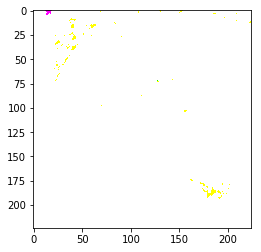

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  ramen
Actual Class:  ramen
CORRECT


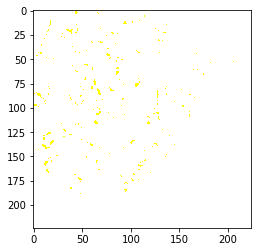

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pad_thai
Actual Class:  pad_thai
CORRECT


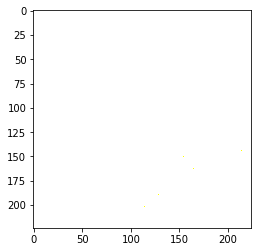

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_bolognese
Actual Class:  spaghetti_bolognese
CORRECT


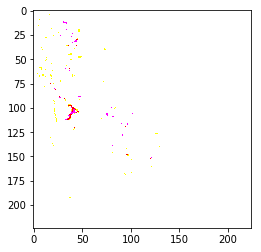

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_bolognese
Actual Class:  spaghetti_bolognese
CORRECT


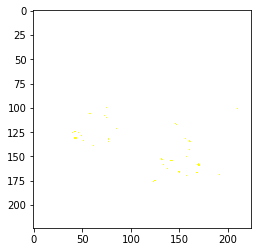

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  ramen
Actual Class:  pho


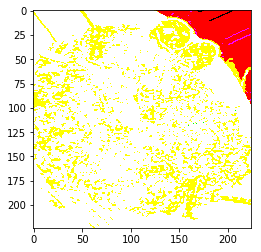

Predicted Class:  ramen
Actual Class:  pad_thai


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


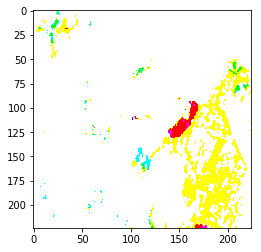

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pho
Actual Class:  pho
CORRECT


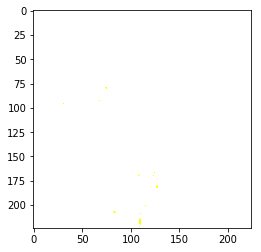

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  ramen
Actual Class:  pad_thai


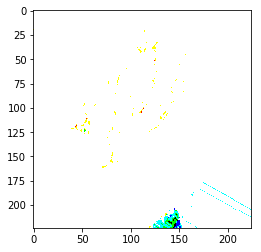

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pho
Actual Class:  pad_thai


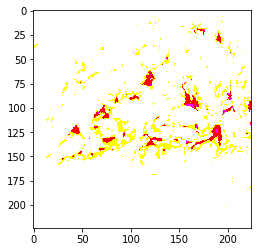

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_bolognese
Actual Class:  pad_thai


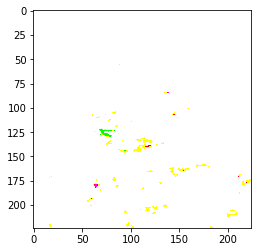

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_carbonara
Actual Class:  spaghetti_carbonara
CORRECT


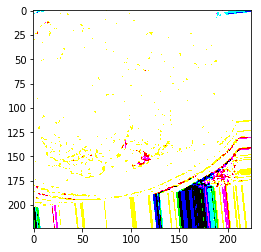

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  ramen
Actual Class:  ramen
CORRECT


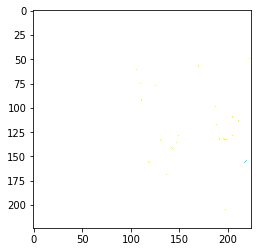

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pad_thai
Actual Class:  pad_thai
CORRECT


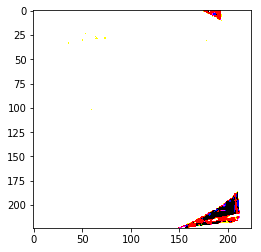

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_carbonara
Actual Class:  spaghetti_carbonara
CORRECT


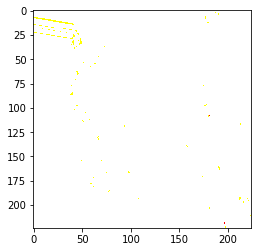

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pad_thai
Actual Class:  pad_thai
CORRECT


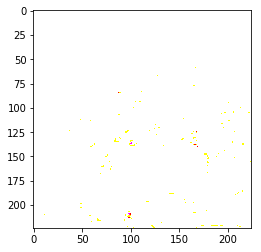

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pad_thai
Actual Class:  pad_thai
CORRECT


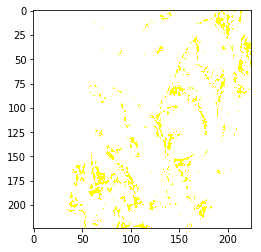

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_carbonara
Actual Class:  spaghetti_carbonara
CORRECT


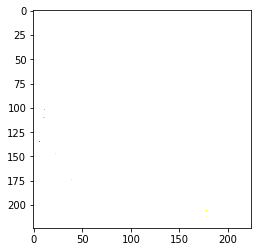

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  ramen
Actual Class:  ramen
CORRECT


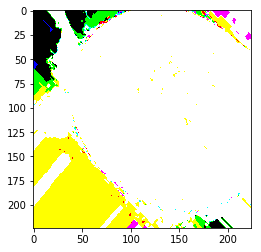

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  ramen
Actual Class:  ramen
CORRECT


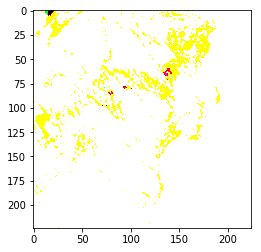

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  ramen
Actual Class:  ramen
CORRECT


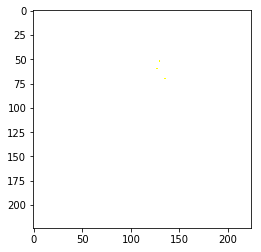

Predicted Class:  pho
Actual Class:  pho
CORRECT


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


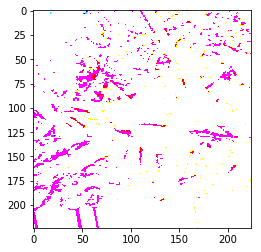

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  ramen
Actual Class:  pad_thai


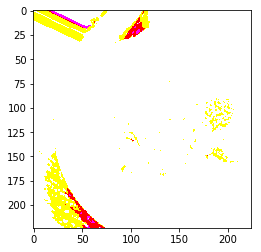

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  ramen
Actual Class:  spaghetti_carbonara


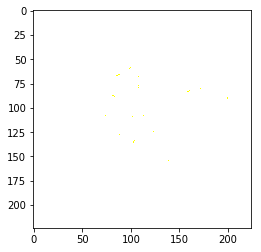

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pad_thai
Actual Class:  pad_thai
CORRECT


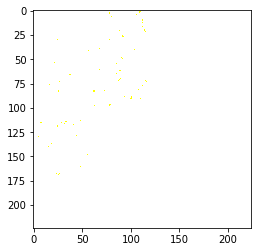

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pad_thai
Actual Class:  pad_thai
CORRECT


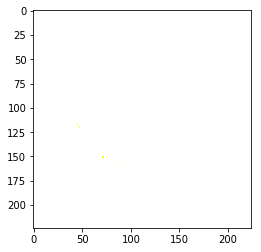

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pho
Actual Class:  pho
CORRECT


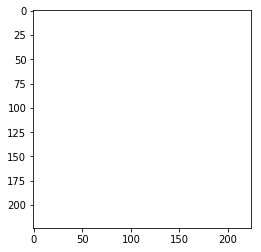

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_carbonara
Actual Class:  spaghetti_carbonara
CORRECT


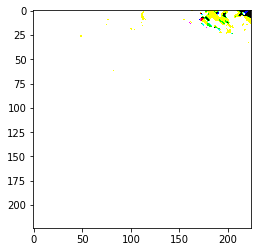

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  ramen
Actual Class:  spaghetti_bolognese


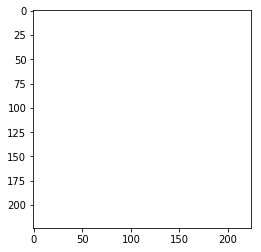

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pho
Actual Class:  pho
CORRECT


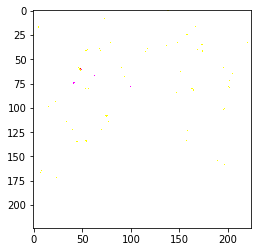

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  ramen
Actual Class:  pad_thai


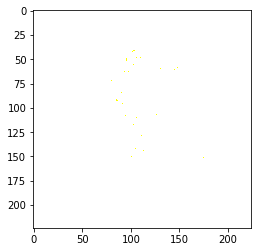

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_bolognese
Actual Class:  spaghetti_bolognese
CORRECT


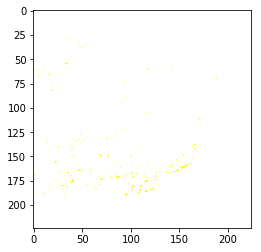

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_bolognese
Actual Class:  spaghetti_carbonara


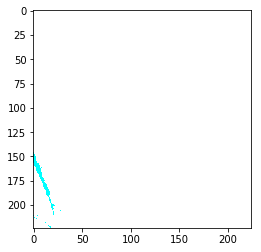

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  ramen
Actual Class:  ramen
CORRECT


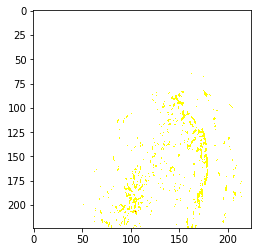

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_bolognese
Actual Class:  spaghetti_bolognese
CORRECT


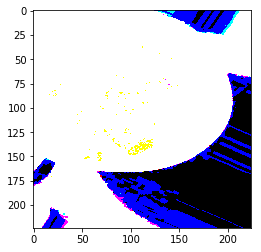

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pho
Actual Class:  pho
CORRECT


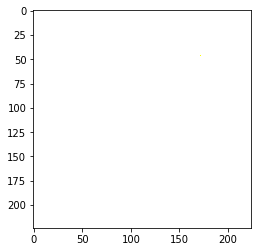

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pho
Actual Class:  pho
CORRECT


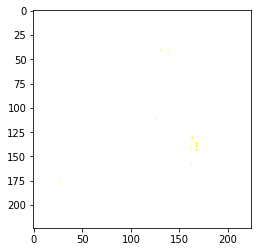

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pho
Actual Class:  pho
CORRECT


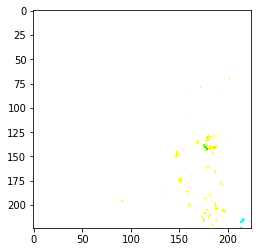

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  ramen
Actual Class:  ramen
CORRECT


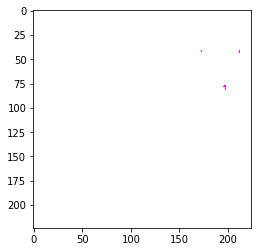

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  ramen
Actual Class:  pad_thai


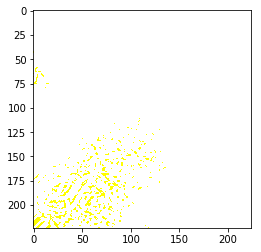

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  ramen
Actual Class:  spaghetti_bolognese


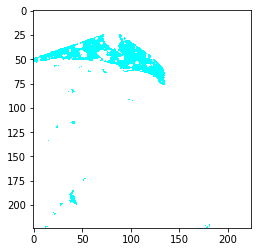

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_bolognese
Actual Class:  spaghetti_bolognese
CORRECT


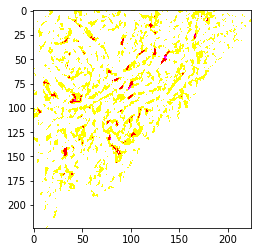

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_bolognese
Actual Class:  pad_thai


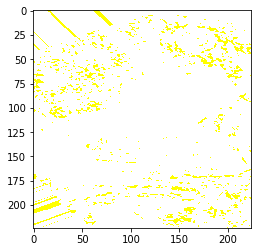

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  ramen
Actual Class:  ramen
CORRECT


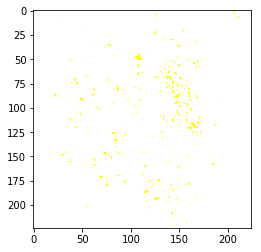

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_carbonara
Actual Class:  spaghetti_carbonara
CORRECT


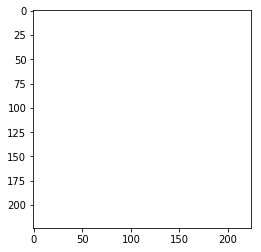

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pho
Actual Class:  pho
CORRECT


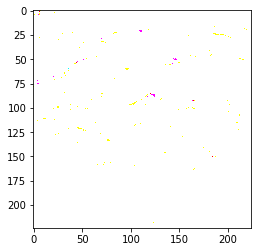

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_bolognese
Actual Class:  pad_thai


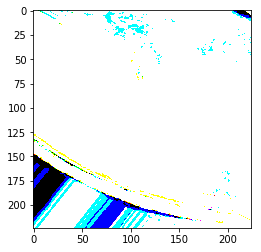

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  ramen
Actual Class:  ramen
CORRECT


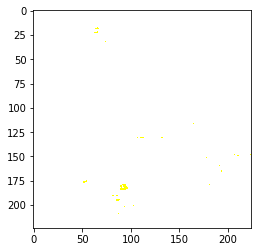

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_carbonara
Actual Class:  spaghetti_carbonara
CORRECT


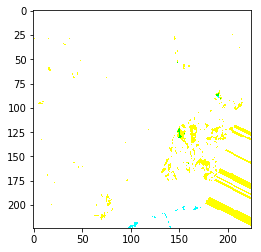

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pho
Actual Class:  pho
CORRECT


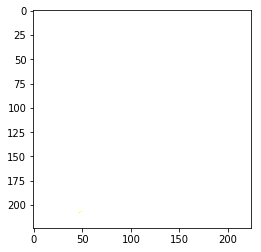

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pho
Actual Class:  pho
CORRECT


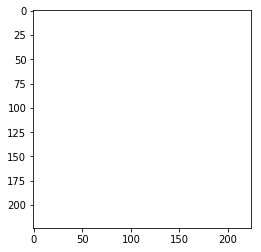

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_carbonara
Actual Class:  spaghetti_carbonara
CORRECT


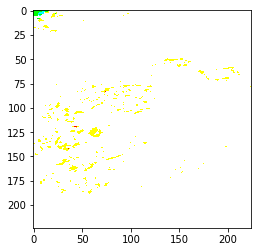

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pho
Actual Class:  pho
CORRECT


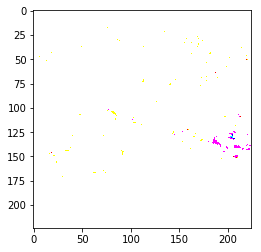

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pad_thai
Actual Class:  pad_thai
CORRECT


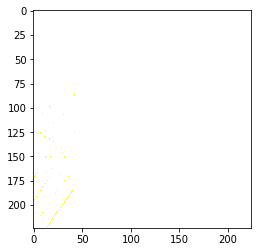

Predicted Class:  ramen
Actual Class:  ramen
CORRECT


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


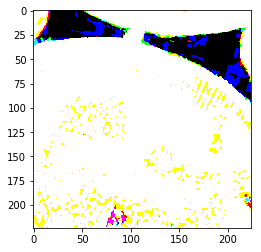

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pad_thai
Actual Class:  ramen


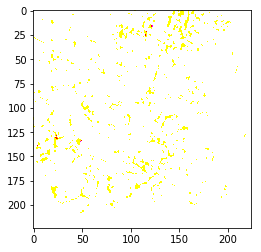

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pad_thai
Actual Class:  pad_thai
CORRECT


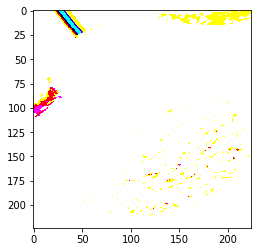

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_bolognese
Actual Class:  spaghetti_bolognese
CORRECT


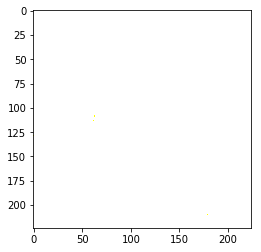

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  ramen
Actual Class:  ramen
CORRECT


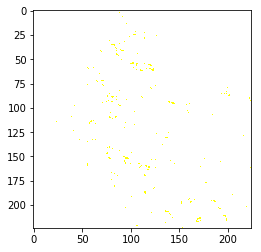

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_carbonara
Actual Class:  spaghetti_carbonara
CORRECT


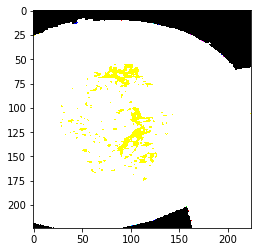

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_bolognese
Actual Class:  spaghetti_bolognese
CORRECT


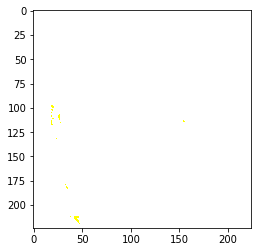

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pho
Actual Class:  pho
CORRECT


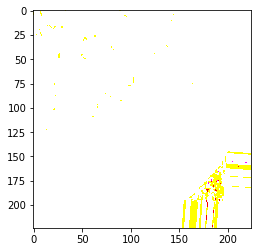

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pho
Actual Class:  pho
CORRECT


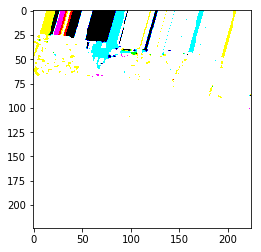

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_carbonara
Actual Class:  spaghetti_carbonara
CORRECT


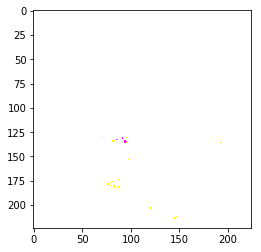

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_carbonara
Actual Class:  spaghetti_carbonara
CORRECT


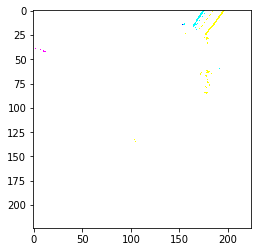

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pho
Actual Class:  pho
CORRECT


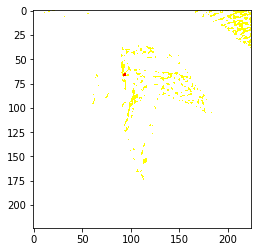

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_carbonara
Actual Class:  pad_thai


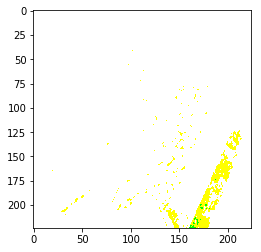

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_bolognese
Actual Class:  spaghetti_bolognese
CORRECT


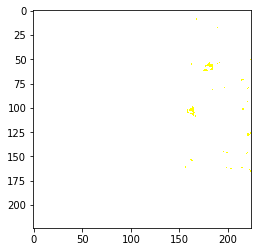

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_carbonara
Actual Class:  spaghetti_carbonara
CORRECT


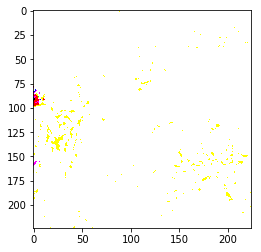

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pho
Actual Class:  pho
CORRECT


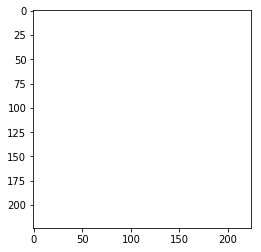

Predicted Class:  pho
Actual Class:  pho
CORRECT


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


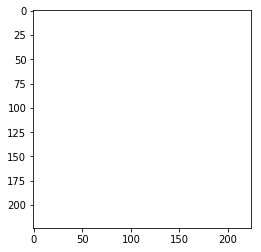

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  ramen
Actual Class:  ramen
CORRECT


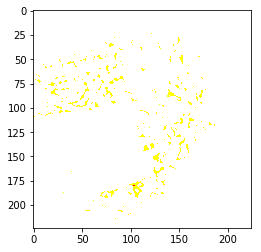

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_bolognese
Actual Class:  spaghetti_bolognese
CORRECT


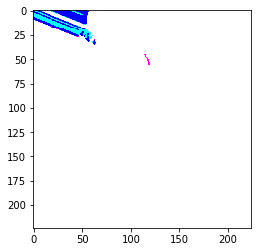

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pho
Actual Class:  pho
CORRECT


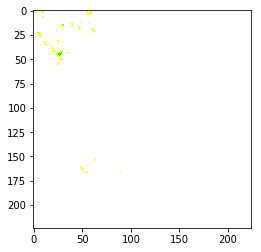

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pho
Actual Class:  pho
CORRECT


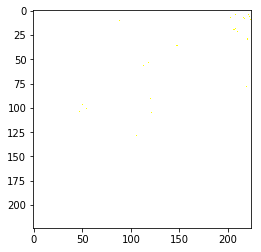

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_bolognese
Actual Class:  ramen


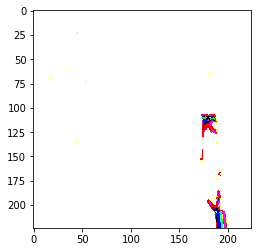

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_carbonara
Actual Class:  spaghetti_carbonara
CORRECT


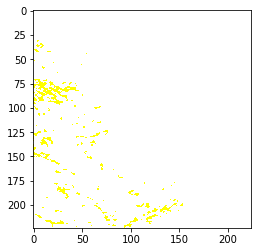

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pad_thai
Actual Class:  pad_thai
CORRECT


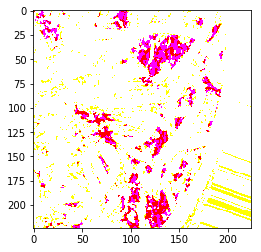

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_bolognese
Actual Class:  spaghetti_bolognese
CORRECT


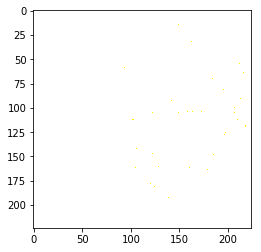

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_carbonara
Actual Class:  spaghetti_bolognese


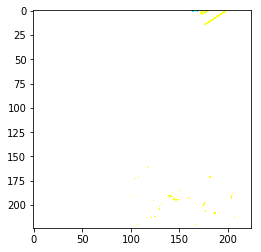

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_carbonara
Actual Class:  spaghetti_carbonara
CORRECT


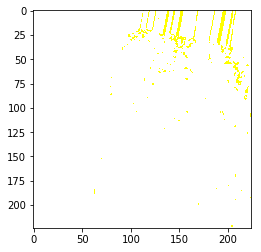

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_bolognese
Actual Class:  spaghetti_bolognese
CORRECT


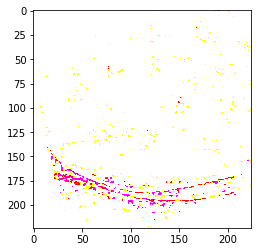

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_carbonara
Actual Class:  spaghetti_bolognese


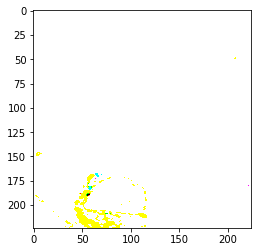

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  ramen
Actual Class:  pho


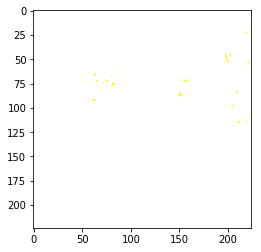

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  ramen
Actual Class:  ramen
CORRECT


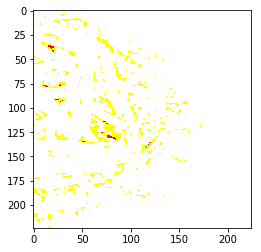

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_bolognese
Actual Class:  spaghetti_bolognese
CORRECT


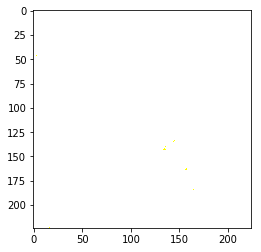

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_carbonara
Actual Class:  spaghetti_carbonara
CORRECT


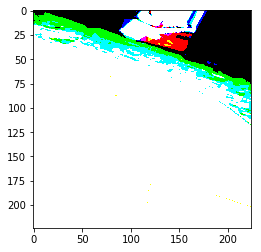

Predicted Class:  pad_thai
Actual Class:  pad_thai
CORRECT


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


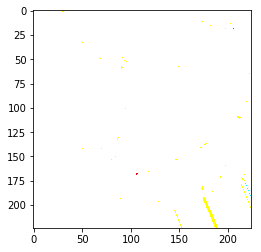

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  ramen
Actual Class:  ramen
CORRECT


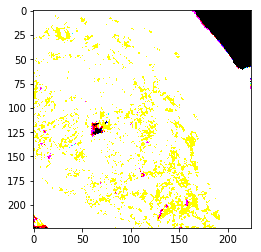

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pad_thai
Actual Class:  pad_thai
CORRECT


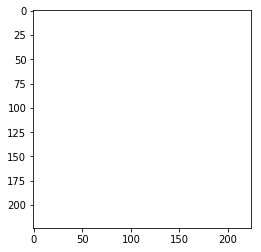

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pho
Actual Class:  pho
CORRECT


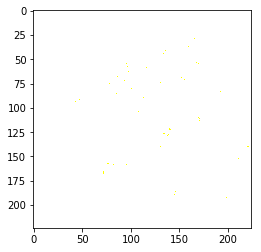

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pad_thai
Actual Class:  pad_thai
CORRECT


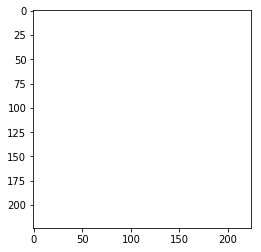

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_carbonara
Actual Class:  spaghetti_carbonara
CORRECT


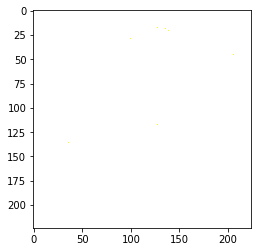

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  ramen
Actual Class:  ramen
CORRECT


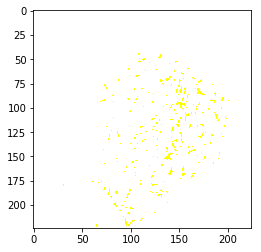

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_bolognese
Actual Class:  spaghetti_bolognese
CORRECT


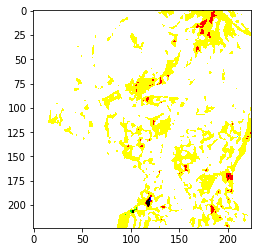

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pad_thai
Actual Class:  pad_thai
CORRECT


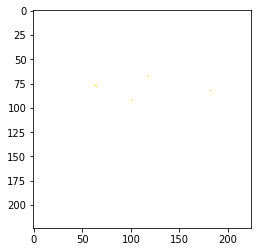

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_carbonara
Actual Class:  spaghetti_carbonara
CORRECT


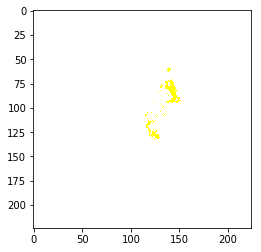

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_carbonara
Actual Class:  spaghetti_carbonara
CORRECT


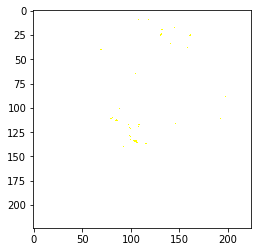

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_bolognese
Actual Class:  spaghetti_bolognese
CORRECT


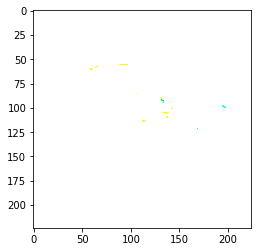

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pad_thai
Actual Class:  pho


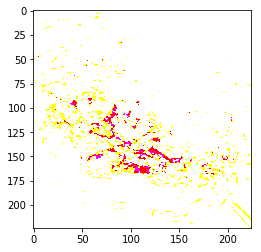

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_bolognese
Actual Class:  spaghetti_bolognese
CORRECT


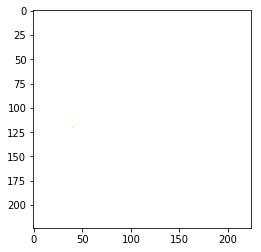

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_bolognese
Actual Class:  spaghetti_bolognese
CORRECT


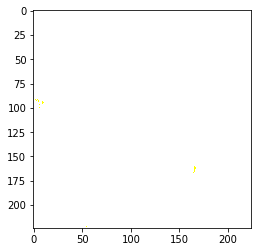

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_carbonara
Actual Class:  spaghetti_carbonara
CORRECT


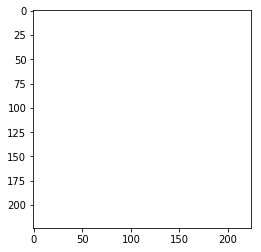

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pho
Actual Class:  pho
CORRECT


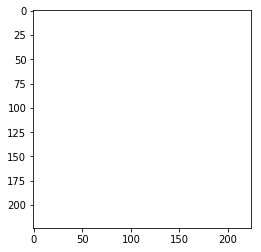

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pho
Actual Class:  pho
CORRECT


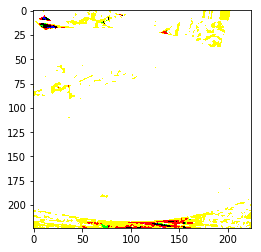

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  ramen
Actual Class:  ramen
CORRECT


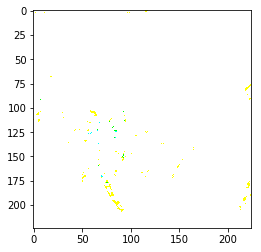

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  ramen
Actual Class:  ramen
CORRECT


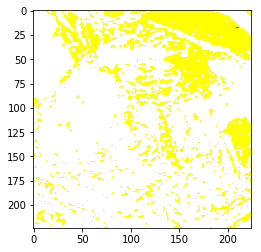

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  ramen
Actual Class:  ramen
CORRECT


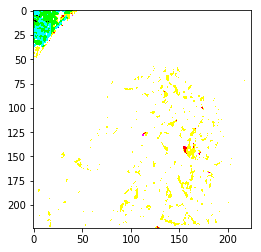

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pad_thai
Actual Class:  spaghetti_carbonara


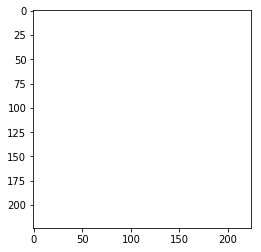

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pad_thai
Actual Class:  pad_thai
CORRECT


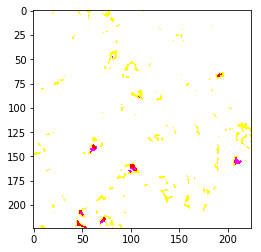

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pad_thai
Actual Class:  pad_thai
CORRECT


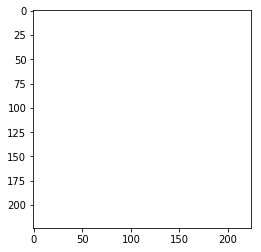

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_carbonara
Actual Class:  spaghetti_carbonara
CORRECT


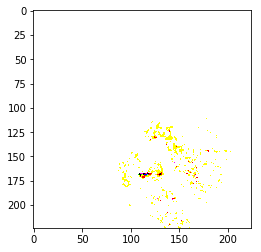

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  ramen
Actual Class:  spaghetti_bolognese


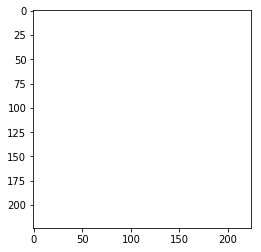

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_bolognese
Actual Class:  spaghetti_bolognese
CORRECT


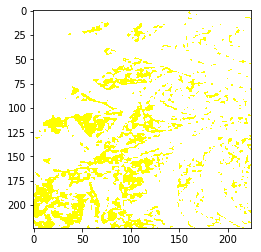

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  ramen
Actual Class:  spaghetti_bolognese


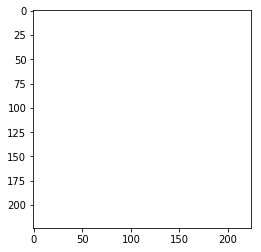

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pho
Actual Class:  pho
CORRECT


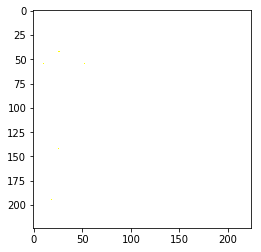

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_bolognese
Actual Class:  spaghetti_bolognese
CORRECT


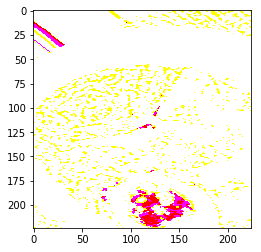

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  ramen
Actual Class:  ramen
CORRECT


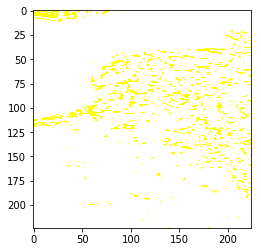

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_carbonara
Actual Class:  pad_thai


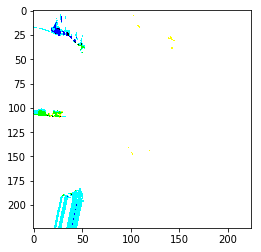

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pho
Actual Class:  pho
CORRECT


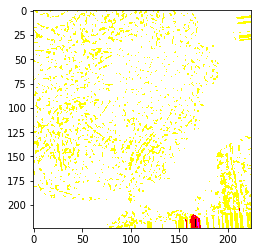

Predicted Class:  pad_thai
Actual Class:  pad_thai
CORRECT


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


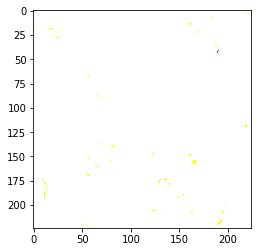

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_carbonara
Actual Class:  spaghetti_carbonara
CORRECT


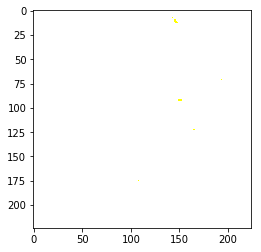

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_carbonara
Actual Class:  spaghetti_carbonara
CORRECT


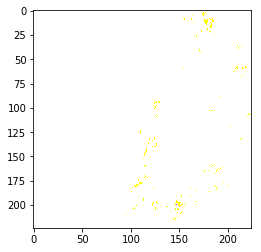

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_carbonara
Actual Class:  spaghetti_carbonara
CORRECT


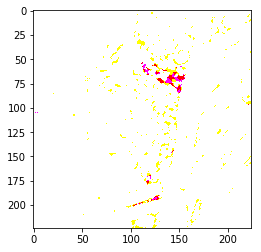

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_bolognese
Actual Class:  spaghetti_bolognese
CORRECT


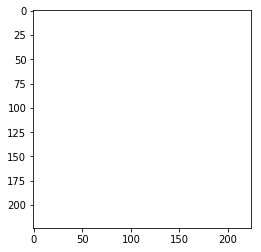

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_carbonara
Actual Class:  spaghetti_carbonara
CORRECT


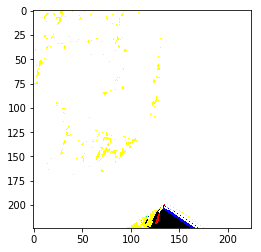

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pho
Actual Class:  ramen


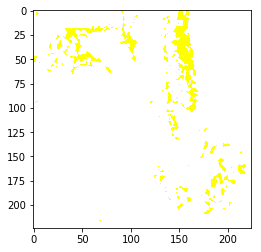

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  ramen
Actual Class:  ramen
CORRECT


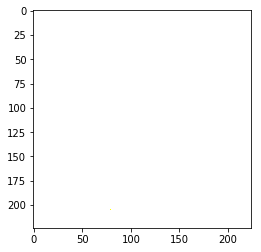

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pho
Actual Class:  pho
CORRECT


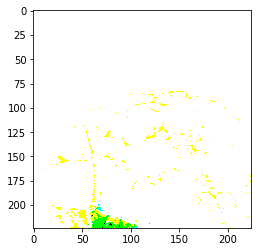

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pho
Actual Class:  ramen


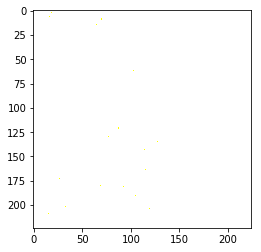

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_carbonara
Actual Class:  spaghetti_carbonara
CORRECT


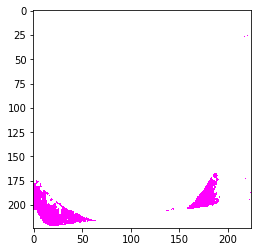

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pho
Actual Class:  pho
CORRECT


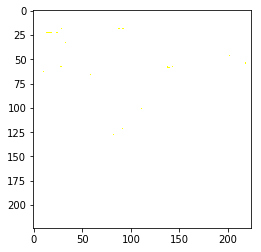

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pad_thai
Actual Class:  pad_thai
CORRECT


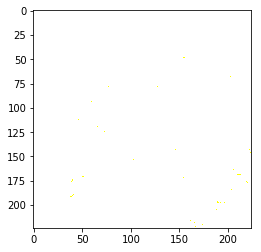

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_bolognese
Actual Class:  spaghetti_bolognese
CORRECT


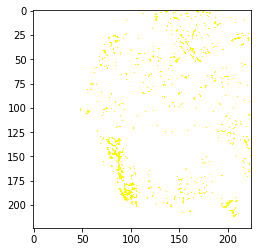

Predicted Class:  pad_thai
Actual Class:  pad_thai
CORRECT


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


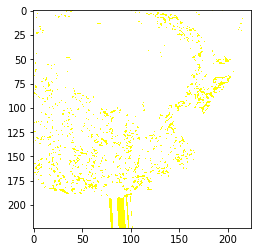

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pad_thai
Actual Class:  spaghetti_bolognese


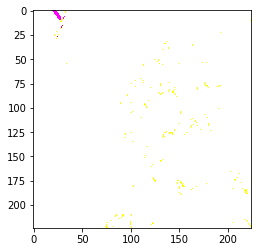

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  ramen
Actual Class:  ramen
CORRECT


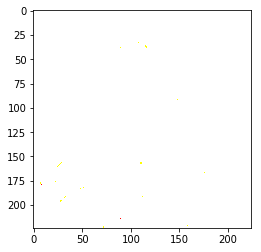

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_bolognese
Actual Class:  spaghetti_bolognese
CORRECT


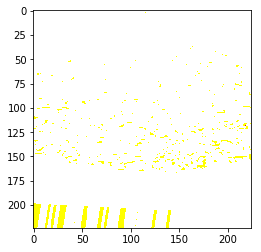

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_bolognese
Actual Class:  pad_thai


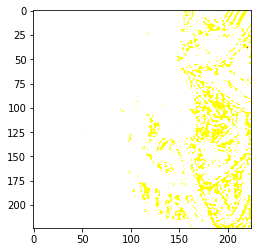

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_carbonara
Actual Class:  spaghetti_carbonara
CORRECT


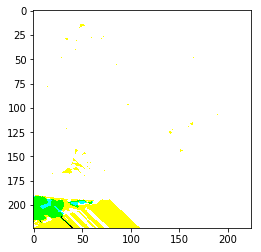

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pad_thai
Actual Class:  pad_thai
CORRECT


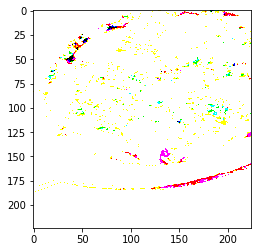

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  ramen
Actual Class:  pho


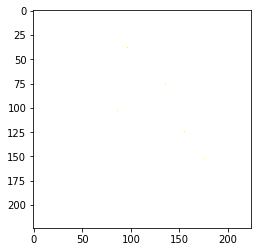

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_carbonara
Actual Class:  spaghetti_carbonara
CORRECT


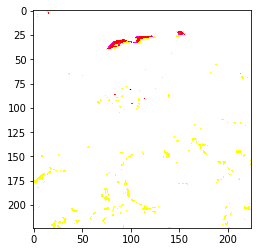

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  ramen
Actual Class:  ramen
CORRECT


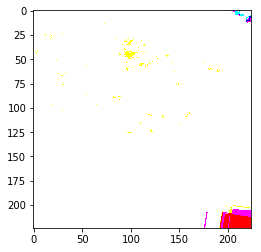

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_carbonara
Actual Class:  spaghetti_carbonara
CORRECT


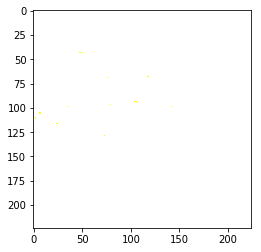

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_bolognese
Actual Class:  spaghetti_bolognese
CORRECT


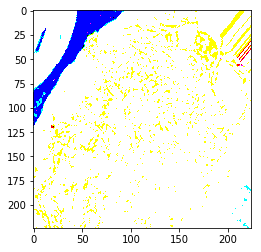

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pad_thai
Actual Class:  pad_thai
CORRECT


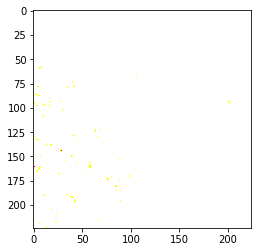

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pad_thai
Actual Class:  spaghetti_bolognese


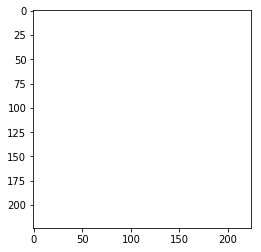

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  ramen
Actual Class:  ramen
CORRECT


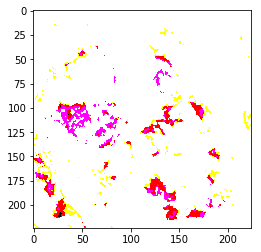

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_bolognese
Actual Class:  spaghetti_carbonara


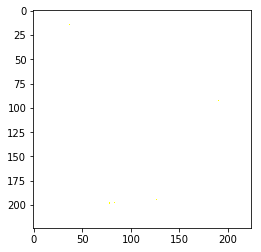

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_carbonara
Actual Class:  spaghetti_carbonara
CORRECT


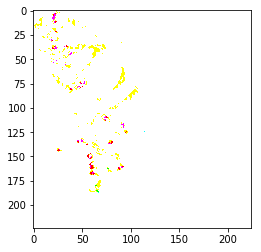

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_carbonara
Actual Class:  spaghetti_carbonara
CORRECT


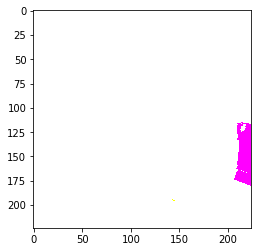

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_carbonara
Actual Class:  spaghetti_bolognese


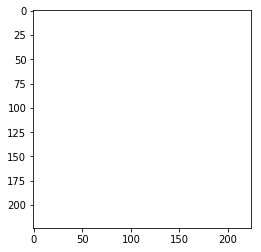

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  ramen
Actual Class:  ramen
CORRECT


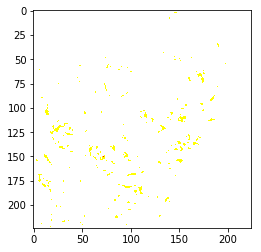

Predicted Class:  spaghetti_carbonara
Actual Class:  spaghetti_carbonara
CORRECT


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


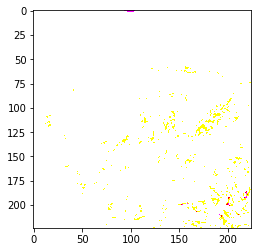

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pad_thai
Actual Class:  pad_thai
CORRECT


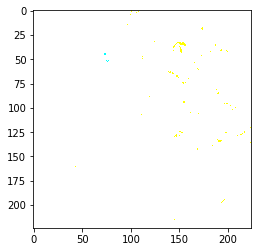

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_carbonara
Actual Class:  spaghetti_carbonara
CORRECT


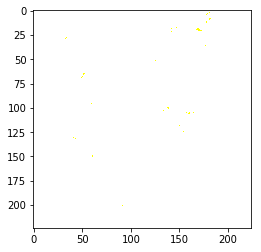

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pho
Actual Class:  pho
CORRECT


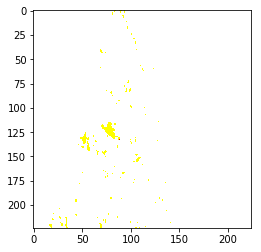

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_bolognese
Actual Class:  spaghetti_bolognese
CORRECT


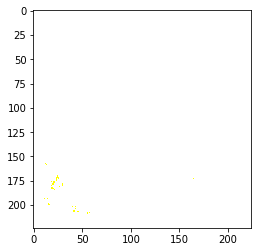

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  ramen
Actual Class:  ramen
CORRECT


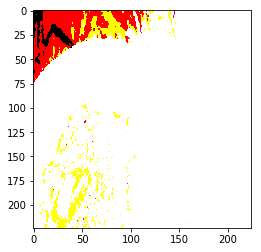

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_bolognese
Actual Class:  spaghetti_bolognese
CORRECT


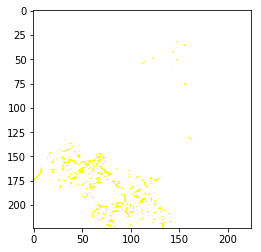

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pho
Actual Class:  pho
CORRECT


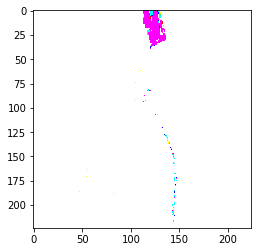

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  ramen
Actual Class:  ramen
CORRECT


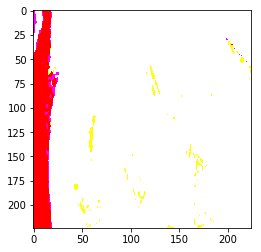

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  ramen
Actual Class:  ramen
CORRECT


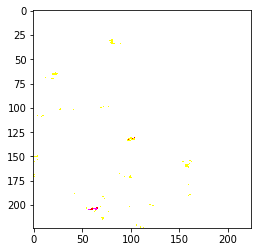

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_carbonara
Actual Class:  spaghetti_carbonara
CORRECT


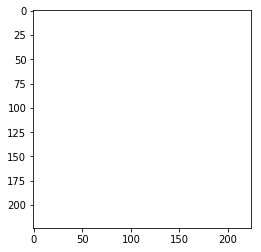

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_bolognese
Actual Class:  pad_thai


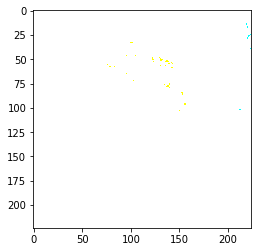

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  ramen
Actual Class:  ramen
CORRECT


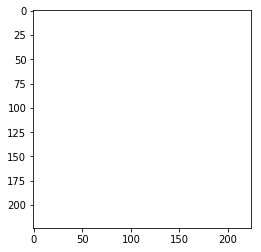

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_carbonara
Actual Class:  spaghetti_carbonara
CORRECT


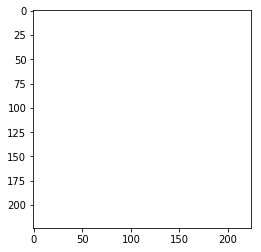

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pho
Actual Class:  pho
CORRECT


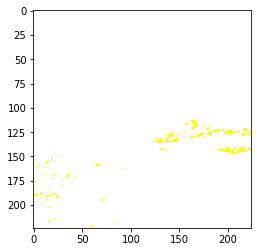

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_bolognese
Actual Class:  spaghetti_carbonara


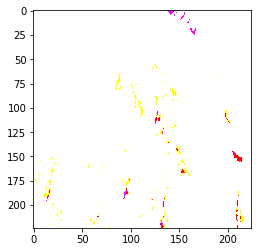

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pad_thai
Actual Class:  pad_thai
CORRECT


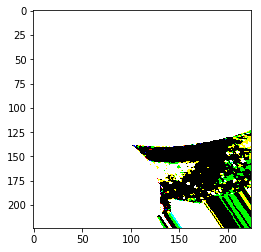

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pho
Actual Class:  pho
CORRECT


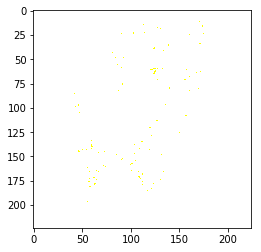

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pad_thai
Actual Class:  pad_thai
CORRECT


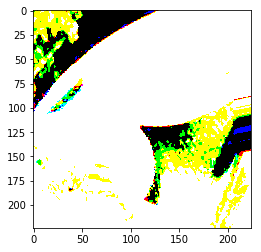

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  ramen
Actual Class:  pho


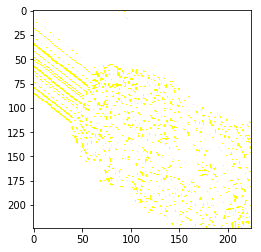

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pad_thai
Actual Class:  pad_thai
CORRECT


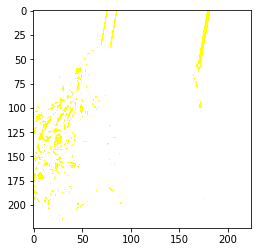

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_carbonara
Actual Class:  spaghetti_carbonara
CORRECT


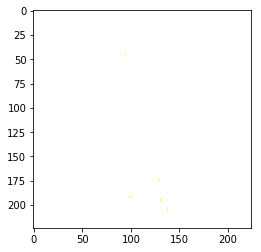

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pad_thai
Actual Class:  pad_thai
CORRECT


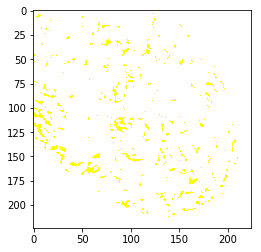

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_bolognese
Actual Class:  spaghetti_carbonara


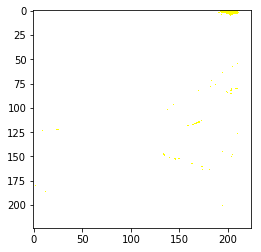

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  ramen
Actual Class:  ramen
CORRECT


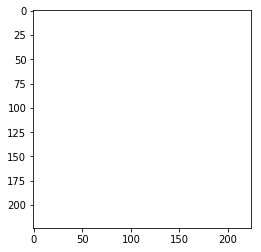

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pho
Actual Class:  pho
CORRECT


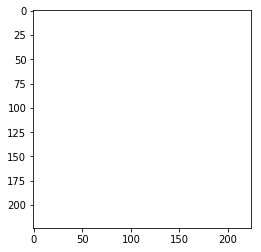

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_carbonara
Actual Class:  spaghetti_carbonara
CORRECT


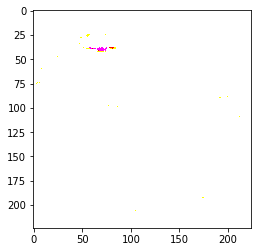

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  ramen
Actual Class:  ramen
CORRECT


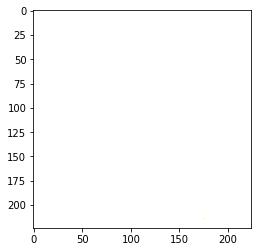

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pho
Actual Class:  pho
CORRECT


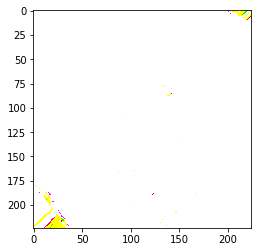

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_bolognese
Actual Class:  pad_thai


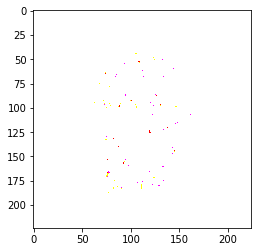

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  spaghetti_bolognese
Actual Class:  spaghetti_bolognese
CORRECT


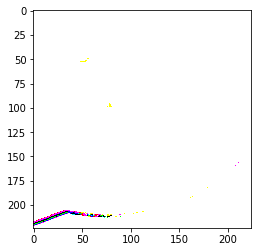

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  pho
Actual Class:  pho
CORRECT


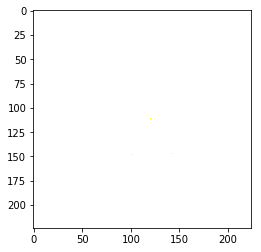

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  ramen
Actual Class:  ramen
CORRECT


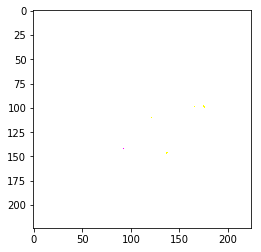

Predicted Class:  spaghetti_bolognese
Actual Class:  spaghetti_bolognese
CORRECT


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


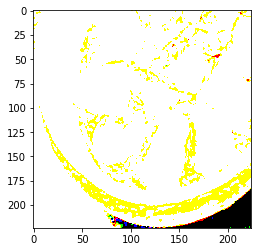

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class:  ramen
Actual Class:  ramen
CORRECT


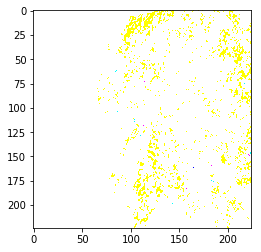

Predicted Class:  pad_thai
Actual Class:  pad_thai
CORRECT


IndexError: index 55 is out of bounds for axis 0 with size 55

In [18]:
count_correct = 0
total = len(X_test)

count_pred = 0
for (a,b) in tdatagener:
    for i in range(0, BATCH_SZ):
        #img = a[i].astype('uint8')
        img = a[i]
        plt.imshow(img, cmap=plt.get_cmap('gray'))
        plt.show()
#        print(x)
        
        pred = noodle_classes[pred_classes[count_pred]]
        actual = noodle_classes[b[i].argmax(axis=-1)]
        
        print("Predicted Class: ", pred)
        #print("Prediction index: ", x.index(max(x)))
        print("Actual Class: ", actual)
        if (pred == actual):
            print("CORRECT")
            count_correct += 1
        count_pred += 1
        
print("SUMMARY")
print("Number correct: ", count_correct)
print("Percent correct: ", count_correct/ total)